### 臺灣新人歌手熱門音樂的各項變數之分布 vs. 臺灣成熟歌手熱門音樂的各項變數之分布

In [ ]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
from scipy.optimize import curve_fit
import time
import itertools
from collections import Counter

#### 一、將資料集分成新人歌手熱門/非熱門音樂資料集、成熟歌手熱門/非熱門音樂資料集
* 定義：如果該熱門歌曲的歌手之第一首發行歌曲的發行年份，距離該熱門歌曲上熱門音樂榜的年份不超過 3 年，即年份相差不超過 2 者，即為新人歌手。距離該熱門歌曲上熱門音樂榜的年份超過 3 年者，則視為成熟歌手。如：a 歌登上 2018 年臺灣熱門音樂榜，a 歌的歌手為 A， 若 A 在平台上的第一首發行歌曲之發行年份為 2018、2019 或 2020 這 3 年其中 1 年，A 則被定義為新人歌手。非熱門歌曲因為沒有上榜，因此無上榜年份，故本研究以 該歌曲發行年份 與 該歌手第一首發行歌曲的發行年份 之差，作為判斷歌曲發行當時，歌手為新人或成熟歌手的標準。

In [ ]:
taiwan_popular = pd.read_excel('18-20 台灣熱門歌曲.xlsx')
taiwan_notPopular = pd.read_excel('18-20 台灣不熱門歌曲.xlsx')
taiwan_21popular = pd.read_excel('21 台灣熱門歌曲.xlsx')
taiwan_21notPopular = pd.read_excel('21 台灣不熱門歌曲.xlsx')

print('Head of dataset:')
display(taiwan_popular.head())
print("Tail of dataset:")
display(taiwan_popular.tail())

# remove column 'Unnamed: 0'
taiwan_popular = taiwan_popular.iloc[:,1:]
taiwan_notPopular = taiwan_notPopular.iloc[:,1:]
taiwan_21popular = taiwan_21popular.iloc[:,1:]
taiwan_21notPopular = taiwan_21notPopular.iloc[:,1:]
taiwan_popular = pd.concat([taiwan_popular, taiwan_21popular])
taiwan_notPopular = pd.concat([taiwan_notPopular, taiwan_21notPopular])

print('size of datasets')
print('18-21 Taiwan popular:', taiwan_popular.shape[0])
print('18-21 Taiwan not popular:', taiwan_notPopular.shape[0])

#### 二、新增所需欄位
* 新增欄位 old_new：1 代表是新人歌手；0 代表成熟歌手
* 新增欄位 experience：熱門歌曲上榜年份 - 歌手第一首發行歌曲的年份，代表歌手年資
* 新增欄位 drama_movie：代表 title 內有提及歌曲是電視劇、電影、影集的音樂

In [ ]:
# add columns
old_new = taiwan_popular["year"] - taiwan_popular["artist_release_year"].apply(lambda x: int(str(x)[:4]))
drama_movie = taiwan_popular["title"].str.contains(pat='連續劇|電視劇|影集|電影', na=False)
taiwan_popular['experience'] = old_new
old_new = old_new.apply(lambda x: 0 if x > 2 else 1)
taiwan_popular["old_new"] = old_new
taiwan_popular["drama_movie"] = drama_movie
taiwan_popular_new = taiwan_popular[taiwan_popular.old_new == 1]
taiwan_popular_old = taiwan_popular[taiwan_popular.old_new == 0]
display(taiwan_popular)

# apply changes to 18-20 Taiwan not popular
old_new = taiwan_notPopular["release_date"].apply(lambda x: x.year) - taiwan_notPopular["artist_release_year"].apply(lambda x: int(x[:4]))
drama_movie = taiwan_notPopular["title"].str.contains(pat='連續劇|電視劇|影集|電影', na=False)
taiwan_notPopular['experience'] = old_new
old_new = old_new.apply(lambda x: 0 if x > 2 else 1)
taiwan_notPopular["old_new"] = old_new
taiwan_notPopular["drama_movie"] = drama_movie
taiwan_notPopular_new = taiwan_notPopular[taiwan_notPopular.old_new == 1]
taiwan_notPopular_old = taiwan_notPopular[taiwan_notPopular.old_new == 0]

print('size of datasets')
print('new artists:', taiwan_popular_new.shape[0] + taiwan_notPopular_new.shape[0] ,'in total')
print('old artists:', taiwan_popular_old.shape[0] + taiwan_notPopular_old.shape[0] ,'in total')

#### 三、資料敘述統計

In [ ]:
print('18-21 臺灣新人歌手的熱門歌曲')
taiwan_popular_new.describe()

18-21 臺灣新人歌手的熱門歌曲


,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,artist_followers,artist_popularity,experience,old_new
count,77.00000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,7.700000e+01,77.000000,77.000000,77.0
mean,0.63239,0.593649,5.324675,-6.311286,0.063044,0.395143,0.000179,0.175205,0.463871,123.256208,215020.415584,2019.558442,4.957887e+06,62.727273,1.610390,1.0
std,0.13189,0.145622,3.736173,2.146007,0.047051,0.258353,0.000877,0.159864,0.201288,30.564079,42960.793422,1.152726,1.025610e+07,15.913943,0.565589,0.0
min,0.25900,0.245000,0.000000,-14.956000,0.027600,0.002610,0.000000,0.059900,0.095100,71.585000,137876.000000,2018.000000,7.310000e+02,34.000000,0.000000,1.0
25%,0.54500,0.499000,1.000000,-7.621000,0.034900,0.198000,0.000000,0.101000,0.327000,97.997000,181599.000000,2019.000000,1.083560e+05,49.000000,1.000000,1.0
50%,0.65700,0.567000,6.000000,-6.283000,0.042700,0.389000,0.000000,0.115000,0.434000,123.593000,205371.000000,2019.000000,3.198900e+05,58.000000,2.000000,1.0
75%,0.72500,0.700000,8.000000,-4.666000,0.069400,0.592000,0.000001,0.153000,0.608000,141.903000,248027.000000,2021.000000,4.149814e+06,77.000000,2.000000,1.0
max,0.90000,0.911000,11.000000,-2.567000,0.253000,0.934000,0.006660,0.900000,0.850000,180.042000,349003.000000,2021.000000,6.200420e+07,90.000000,2.000000,1.0


In [ ]:
print('18-21 臺灣新人歌手的非熱門歌曲')
taiwan_notPopular_new.describe()

18-21 臺灣新人歌手的非熱門歌曲


,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,artist_followers,artist_popularity,experience,old_new
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.0,1.490000e+02,149.000000,149.000000,149.0
mean,0.593059,0.558472,5.463087,-8.097483,0.054111,0.434217,0.067659,0.159680,0.431817,121.065349,224343.557047,0.0,3.763196e+04,18.946309,1.375839,1.0
std,0.146470,0.206147,3.627082,3.699950,0.049524,0.300224,0.224364,0.102533,0.225597,27.111000,57056.674503,0.0,3.076237e+05,14.865971,0.485972,0.0
min,0.081400,0.004300,0.000000,-21.798000,0.025200,0.000612,0.000000,0.051800,0.033500,74.999000,68097.000000,0.0,0.000000e+00,0.000000,1.000000,1.0
25%,0.536000,0.423000,2.000000,-9.481000,0.030700,0.149000,0.000000,0.097100,0.265000,98.171000,193868.000000,0.0,5.500000e+01,5.000000,1.000000,1.0
50%,0.618000,0.556000,6.000000,-7.521000,0.038700,0.411000,0.000000,0.121000,0.425000,120.151000,216938.000000,0.0,3.920000e+02,19.000000,1.000000,1.0
75%,0.695000,0.686000,9.000000,-5.802000,0.059000,0.703000,0.000057,0.173000,0.577000,135.976000,243958.000000,0.0,3.285000e+03,29.000000,2.000000,1.0
max,0.868000,0.981000,11.000000,-2.683000,0.357000,0.988000,0.975000,0.667000,0.956000,208.166000,576273.000000,0.0,3.672522e+06,85.000000,2.000000,1.0


In [ ]:
print('18-21 臺灣成熟歌手的熱門歌曲')
taiwan_popular_old.describe()

18-21 臺灣成熟歌手的熱門歌曲


,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,artist_followers,artist_popularity,experience,old_new
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,6.660000e+02,666.000000,666.000000,666.0
mean,0.590348,0.557801,5.606607,-6.863071,0.060110,0.385613,0.001779,0.149195,0.402114,122.451526,234326.342342,2019.524024,1.177219e+07,66.424925,9.903904,0.0
std,0.137776,0.174534,3.604285,2.407323,0.059574,0.296704,0.026728,0.107328,0.192614,28.772974,44731.252326,1.118616,2.118224e+07,15.325381,5.706065,0.0
min,0.240000,0.096200,0.000000,-16.476000,0.023200,0.001460,0.000000,0.021500,0.049900,64.002000,140533.000000,2018.000000,1.178000e+03,1.000000,3.000000,0.0
25%,0.497750,0.439000,2.000000,-8.234000,0.031700,0.106000,0.000000,0.093100,0.257250,98.289250,199068.250000,2019.000000,2.954922e+05,55.000000,5.000000,0.0
50%,0.584500,0.559000,6.000000,-6.657000,0.039350,0.351000,0.000000,0.112000,0.368000,123.942500,229553.000000,2020.000000,1.255999e+06,63.000000,9.000000,0.0
75%,0.698750,0.685000,9.000000,-5.061250,0.059775,0.636000,0.000003,0.156000,0.526500,140.836500,265800.000000,2021.000000,1.554656e+07,81.000000,13.000000,0.0
max,0.935000,0.979000,11.000000,-1.573000,0.473000,0.975000,0.657000,0.926000,0.952000,208.225000,380800.000000,2021.000000,9.692974e+07,95.000000,29.000000,0.0


In [ ]:
print('18-21 臺灣成熟歌手的非熱門歌曲')
taiwan_notPopular_old.describe()

18-21 臺灣成熟歌手的非熱門歌曲


,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,artist_followers,artist_popularity,experience,old_new
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.0,1.960000e+02,196.000000,196.000000,196.0
mean,0.555413,0.532144,5.545918,-8.140566,0.058968,0.489382,0.059291,0.160068,0.390153,121.640490,236861.545918,0.0,6.807428e+05,27.137755,11.918367,0.0
std,0.154627,0.203820,3.619454,3.480539,0.063327,0.314623,0.201726,0.118588,0.224636,28.209541,68088.326660,0.0,4.905405e+06,21.216259,16.059935,0.0
min,0.128000,0.053200,0.000000,-21.490000,0.023900,0.000337,0.000000,0.033900,0.045700,66.053000,68660.000000,0.0,0.000000e+00,0.000000,3.000000,0.0
25%,0.456250,0.400000,2.000000,-9.441000,0.031025,0.163000,0.000000,0.091125,0.224000,100.993000,200962.750000,0.0,1.202500e+02,7.000000,3.750000,0.0
50%,0.562000,0.537500,5.500000,-7.667000,0.037400,0.558000,0.000000,0.117000,0.323500,125.829000,227744.500000,0.0,1.471000e+03,25.000000,8.000000,0.0
75%,0.663250,0.654000,9.000000,-5.821500,0.060625,0.741750,0.000034,0.180000,0.557250,139.391250,267000.000000,0.0,2.497175e+04,41.500000,12.250000,0.0
max,0.929000,0.996000,11.000000,-2.479000,0.565000,0.991000,0.932000,0.979000,0.962000,199.320000,616759.000000,0.0,6.055661e+07,93.000000,120.000000,0.0


In [ ]:
def histogram(df_s, xlabel, status1, status2):
    fig, ax1 = plt.subplots()
    counts, bins, patches = plt.hist(df_s, bins='auto', density=False, facecolor='#2ab0ff', edgecolor='#e0e0e0', alpha=0.75)

    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(f"Histogram of {xlabel} for {status1} artists' {status2} songs")

    plt.show()
    
def qqplot(df_s):
    fig = sm.qqplot(df_s, stats.norm, fit=True, line='45')
    
def shapiro(df_s):
    stat, p = stats.shapiro(df_s)
    if p > 0.05:
        print(f"Since p value = {p:.4f} > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution is normal.")
    else:
        print(f"Since p value = {p:.4f} < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.")
        
        
def wilcoxonRankSumTest(df_s1, df_s2, tc, pop1, pop2, tg, greater = 1):
    if greater:
        res = stats.mannwhitneyu(df_s1, df_s2, alternative='greater')
    else:
        res = stats.mannwhitneyu(df_s1, df_s2, alternative='less')
    pvalue = res.pvalue
    if greater:
        if pvalue > 0.05:
            print(f"Since p value = {pvalue:.4f} > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.")
            print(f'Therefore, {tc} may not be a factor that affects the music popularity of {tg} artists.')
        else:
            print(f"Since p value = {pvalue:.4f} < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of {tc} for {pop1} is to the right of the location of {tc} for {pop2}.")
            print(f'Therefore, {tc} may be a factor that affects the music popularity of {tg} artists.')
    else:
        if pvalue > 0.05:
            print(f"Since p value = {pvalue:.4f} > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.")
            print(f'Therefore, {tc} may not be a factor that affects the music popularity of {tg} artists.')
        else:
            print(f"Since p value = {pvalue:.4f} < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of {tc} for {pop1} is to the left of the location of {tc} for {pop2}.")
            print(f'Therefore, {tc} may be a factor that affects the music popularity of {tg} artists.')
    
        
def t_test(samp1, samp2, equal):
    # t-test using sms.CompareMeans
    cm = sms.CompareMeans(sms.DescrStatsW(samp1), sms.DescrStatsW(samp2))
    # usevarstr, ‘pooled’ or ‘unequal’
    print('The p value is for two tailed, so for one tail test, real p value is pval/2')
    if equal:
        print(cm.summary(usevar='pooled', alpha=0.05))
    else:
        print(cm.summary(usevar='unequal', alpha=0.05))
        
def simple_equal_var_test_and_t_test(samp1, samp2, verbal = False):
    '''A simple F test for equal variance'''
    # 去除NAN
    samp1 = samp1[~np.isnan(samp1)]
    samp2 = samp2[~np.isnan(samp2)]
    #if verbal:
        #print("samp1 (for numerator) = \n", samp1)
        #print("samp2 (for denominator) = \n", samp2)
    df_num = samp1.shape[0] - 1
    df_denom = samp2.shape[0] - 1

    #print("df_num = ", df_num)
    #print("df_denom = ", df_denom)
    var1 = stats.describe(samp1).variance
    var2 = stats.describe(samp2).variance
    #print(f"Variance 1 (numerator) = {var1:.4f}")
    #print(f"Variance 2 (denominator) = {var2:.4f}")
    var_ratio = var1 / var2
    #print(f"var_ratio (F value) = {var_ratio:.4f}")

    ptmp = stats.f.cdf(var_ratio, df_num, df_denom)
    p_value_left = ptmp
    p_value_right = 1 - ptmp
    if ptmp > 0.5:
        ptmp = 1 - ptmp
    p_value = ptmp * 2
    if p_value > 0.05:
        print(f"Since p value = {p_value:.4f} > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the variance are equal. Then, we apply equal variance t test. \n")
        t_test(samp1, samp2, equal = True)
    else:
        print(f"Since p value = {p_value:.4f} < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the variance are unequal. Then, we apply unequal variance t test. \n")
        t_test(samp1, samp2, equal = False)
        
    #print(f"p_value (right tail) = {p_value_right:.4f}")
    #print(f"p_value (left tail) = {p_value_left:.4f}")

#### 四、新人歌手的熱門 / 非熱門音樂
#### 1. 新人歌手的熱門 / 非熱門音樂在各項變數的分布
* 變數共有 danceability、energy、key、loudness、acousticness、liveness、valence、tempo、duration_ms、artist_followers、artist_popularity、experience、是否為電視劇或電影配樂，共 13 項變數
* 探討新人歌手的熱門音樂在該項變數的分布 vs. 新人歌手的非熱門音樂在該項變數的分布 有何不同

In [ ]:
targetGroup = 'new'
pop1 = '2018-2021 臺灣新人歌手的熱門歌曲'
pop2 = '2018-2021 臺灣新人歌手的非熱門歌曲'
df_p = taiwan_popular_new
df_np = taiwan_notPopular_new

#### (1) danceability

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

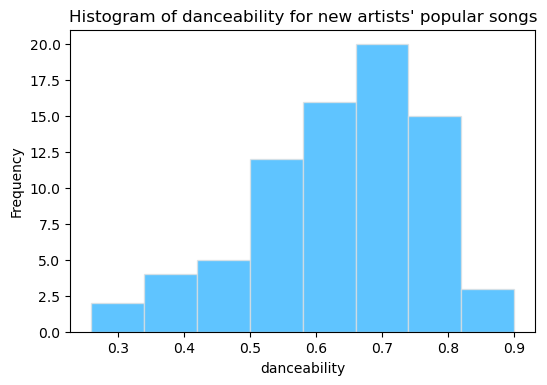

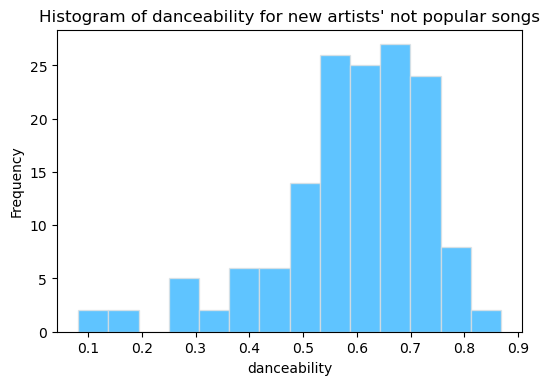

Since p value = 0.0275 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


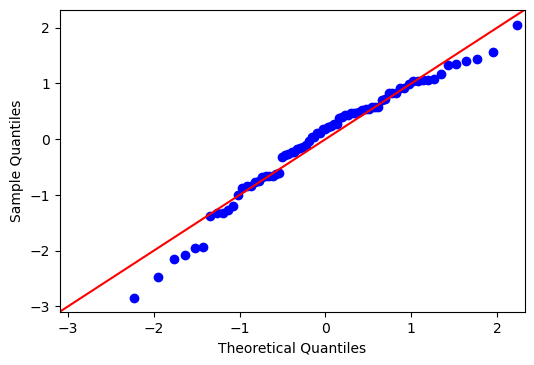

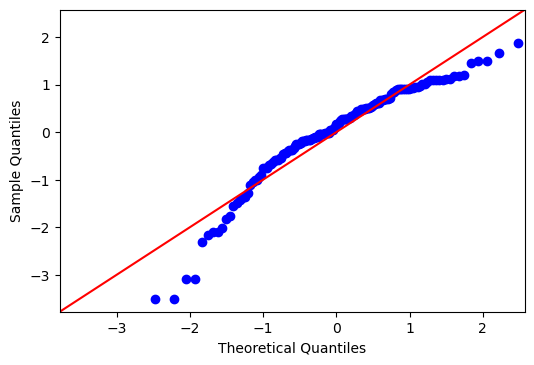

In [ ]:
targetCol = 'danceability'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

According to the results from Shapiro test, we can infer at 5% significance level that the distribution isn't normal. So we should apply wilcoxon rank sum test.

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of danceability for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of danceability for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of danceability for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.0271 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of danceability for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of danceability for 2018-2021 臺灣新人歌手的非熱門歌曲.
Therefore, danceability may be a factor that affects the music popularity of new artists.


#### (2) energy

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

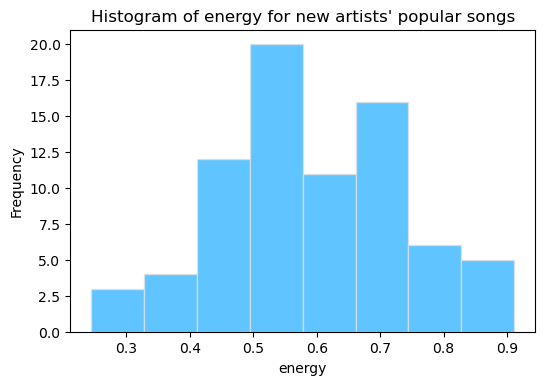

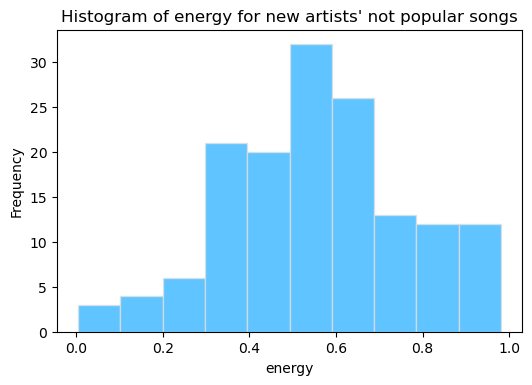

Since p value = 0.7754 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution is normal.
Since p value = 0.2947 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution is normal.


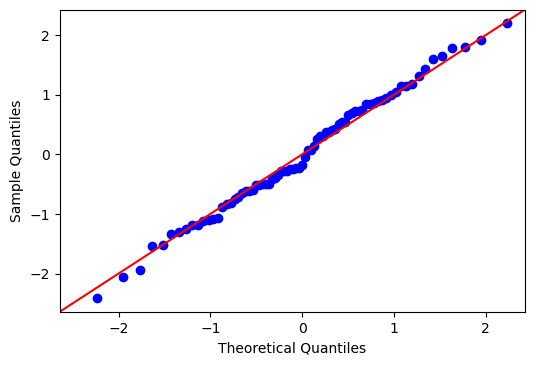

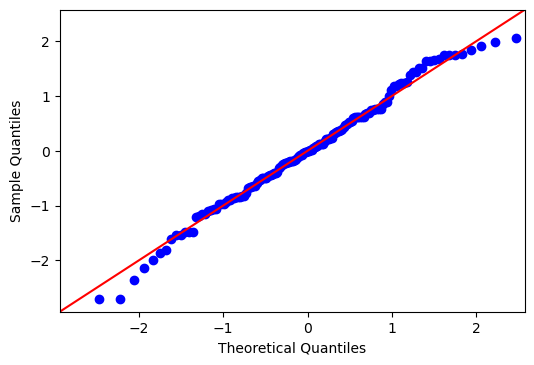

In [ ]:
targetCol = 'energy'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

According to the results from Shapiro test, we can infer at 5% significance level that the distribution is normal. So we should apply t test.

#### check required conditions
1. two independent samples
2. population are normally distributed (so that the samples are normally distributed)

Since all required conditions are met, we can apply F test.

let the mean and variance of energy of popular songs from new artists be $\mu_1$ and $\sigma_1^2$ <br/>
let the mean and variance of energy of not popular songs from new artists be $\mu_2$ and $\sigma_2^2$

[ hypothesis for F test ] <br>
let H0 : $\sigma_1^2 / \sigma_2^2 = 1$ <br/>
let H1 : $\sigma_1^2 / \sigma_2^2 \ne 1$

[ hypothesis for t test ]<br>
let H0 : $\mu_1 - \mu_2 = 0$ <br/>
let H1 : $\mu_1 - \mu_2 \neq 0$

In [ ]:
simple_equal_var_test_and_t_test(popular, notPopular)

Since p value = 0.0010 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the variance are unequal. Then, we apply unequal variance t test. 

The p value is for two tailed, so for one tail test, real p value is pval/2
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.0352      0.024      1.486      0.139      -0.012       0.082


Because p value = 0.139 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that energy of popular songs from new artists is about the same as energy of not popular songs from new artists. So energy may not be a factor that affects the music popularity of new artists.

#### (3) key

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

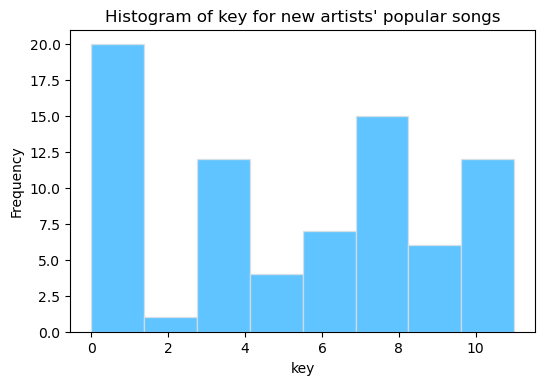

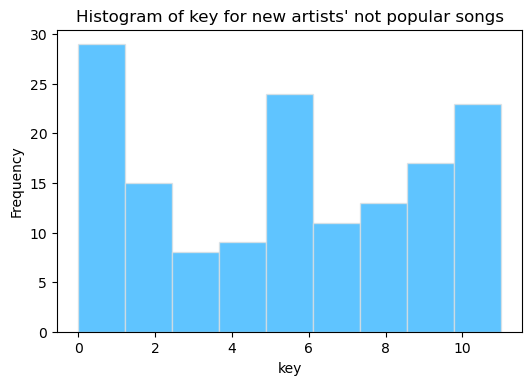

Since p value = 0.0001 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


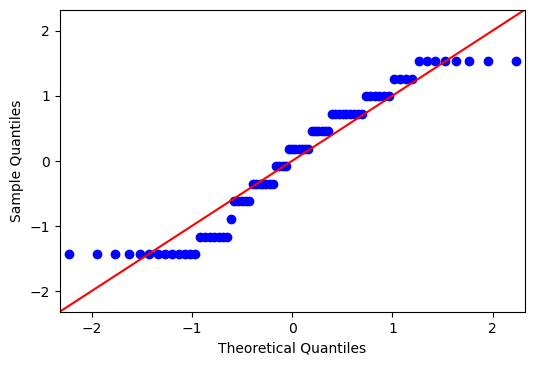

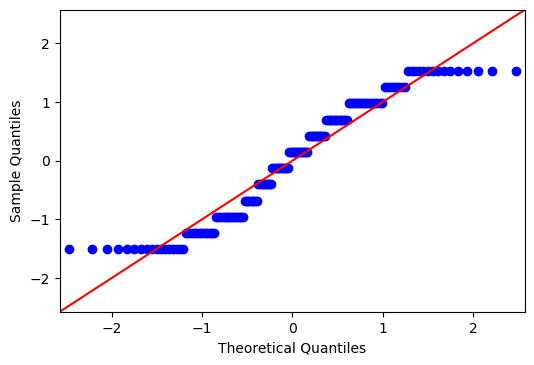

In [ ]:
targetCol = 'key'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

According to the results from Shapiro test, we can infer at 5% significance level that the distribution isn't normal. So we should apply wilcoxon rank sum test.

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of key for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of key for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of key for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.6313 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, key may not be a factor that affects the music popularity of new artists.


#### (4) loudness

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

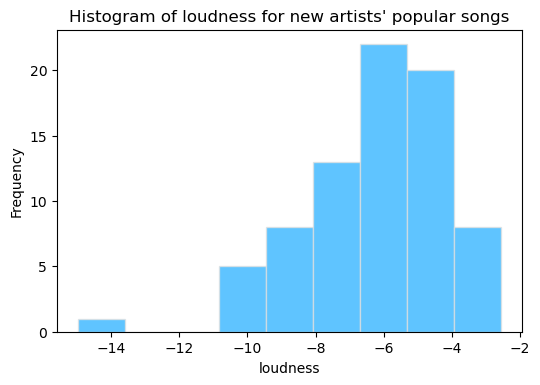

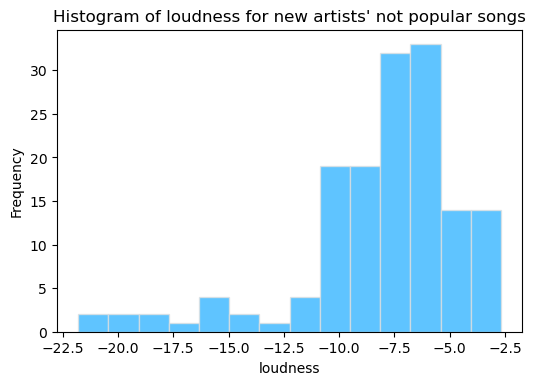

Since p value = 0.0021 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


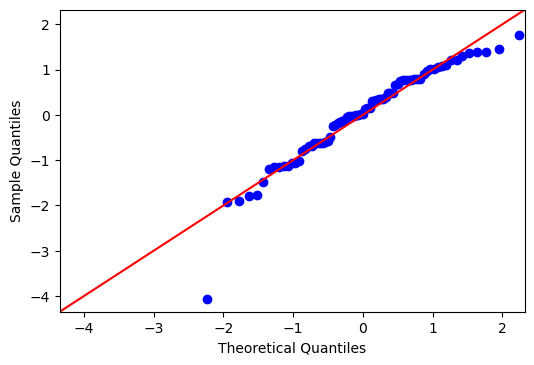

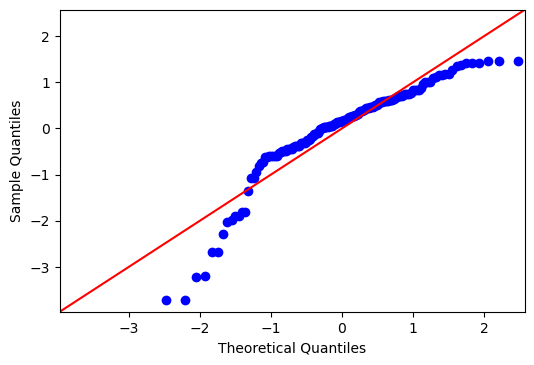

In [ ]:
targetCol = 'loudness'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of loudness for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of loudness for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of loudness for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.0001 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of loudness for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of loudness for 2018-2021 臺灣新人歌手的非熱門歌曲.
Therefore, loudness may be a factor that affects the music popularity of new artists.


#### (5) acousticness

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

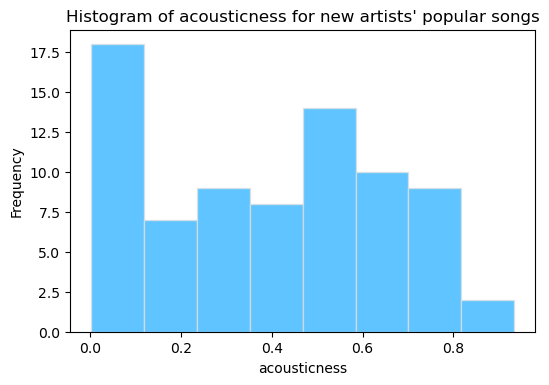

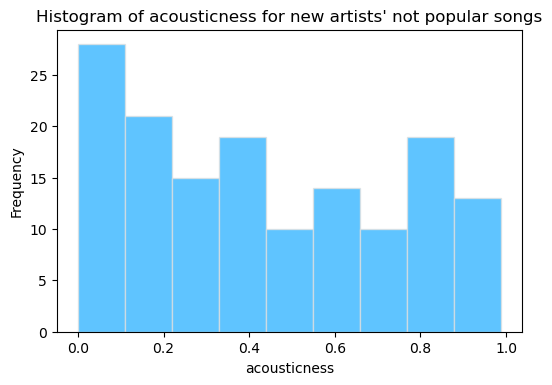

Since p value = 0.0031 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


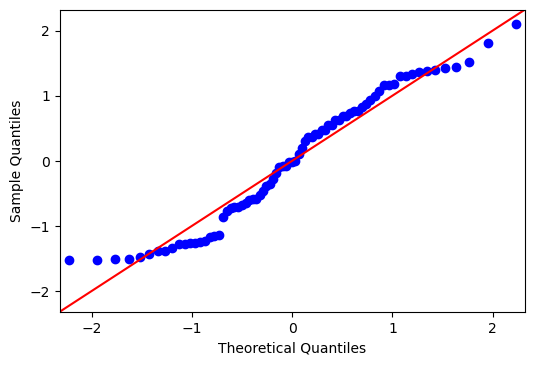

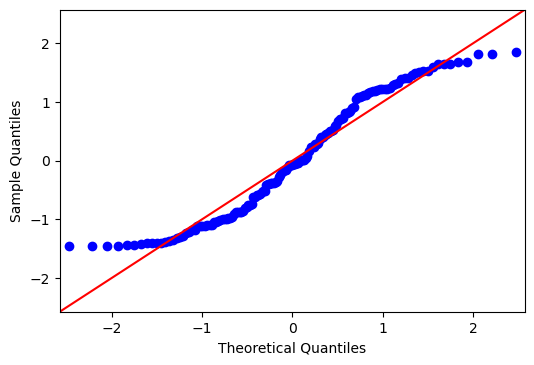

In [ ]:
targetCol = 'acousticness'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the left of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup, greater = 0)

H0: The locations of acousticness for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of acousticness for 2018-2021 臺灣新人歌手的熱門歌曲 is to the left of the location of acousticness for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.1763 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, acousticness may not be a factor that affects the music popularity of new artists.


#### (6) liveness

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

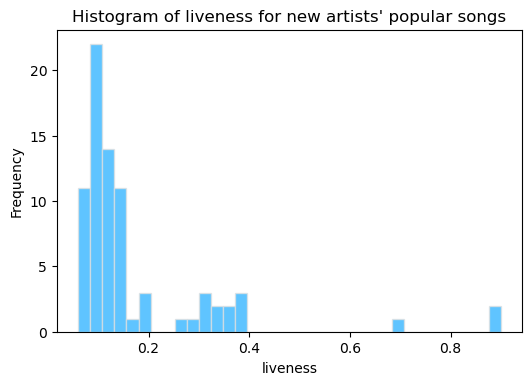

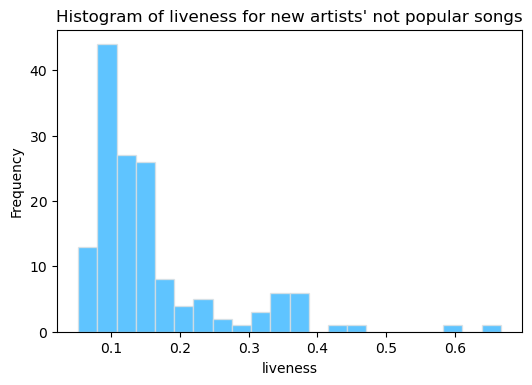

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


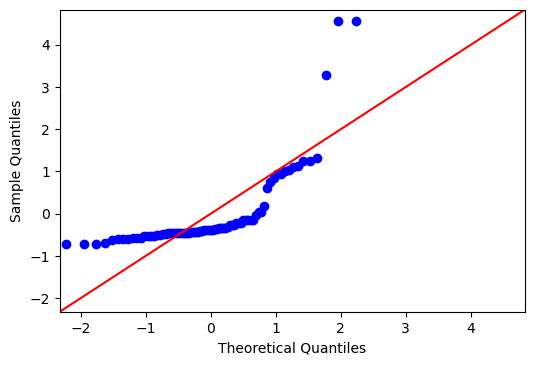

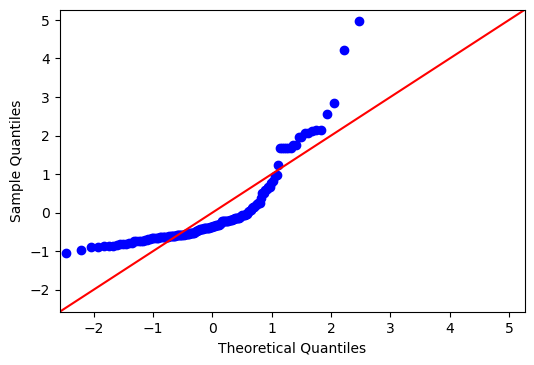

In [ ]:
targetCol = 'liveness'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of liveness for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of liveness for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of liveness for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.6611 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, liveness may not be a factor that affects the music popularity of new artists.


#### (7) valence

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

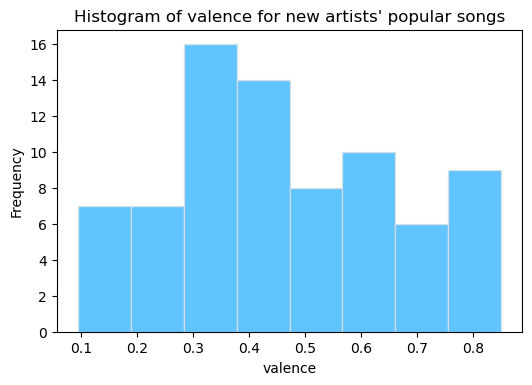

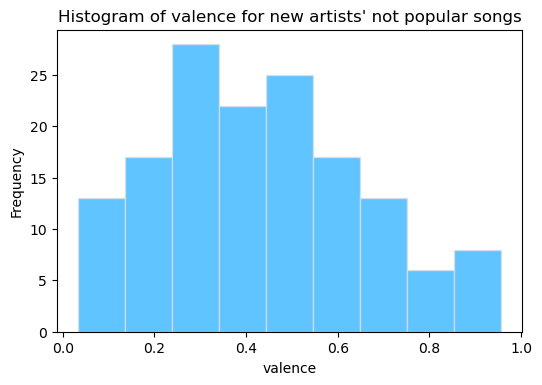

Since p value = 0.0317 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0072 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


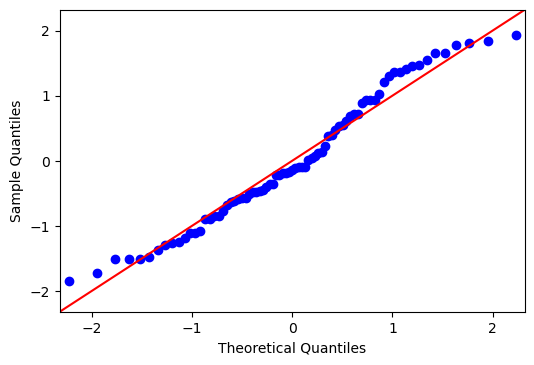

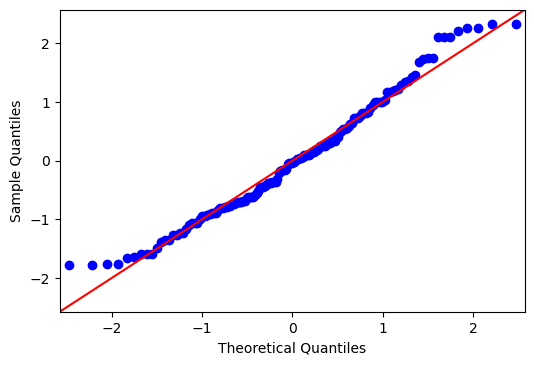

In [ ]:
targetCol = 'valence'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of valence for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of valence for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of valence for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.1329 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, valence may not be a factor that affects the music popularity of new artists.


#### (8) tempo

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

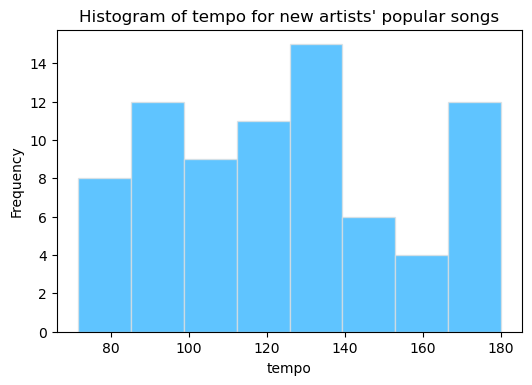

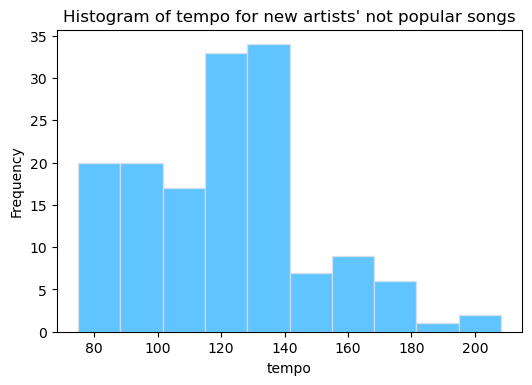

Since p value = 0.0088 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0026 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


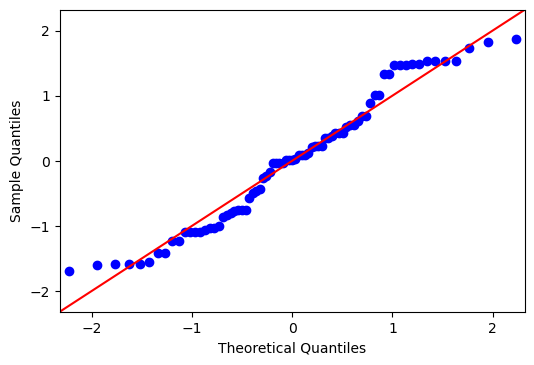

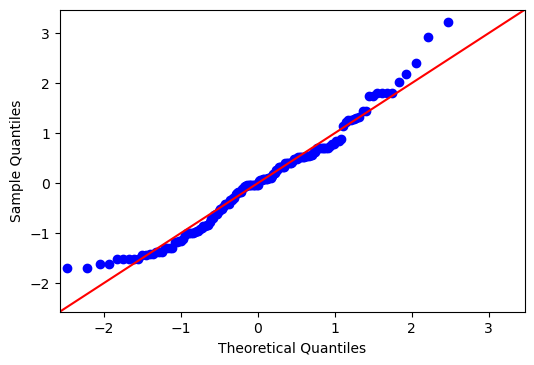

In [ ]:
targetCol = 'tempo'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the left of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup, greater = 0)

H0: The locations of tempo for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of tempo for 2018-2021 臺灣新人歌手的熱門歌曲 is to the left of the location of tempo for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.6957 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, tempo may not be a factor that affects the music popularity of new artists.


#### (9) duration_ms

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

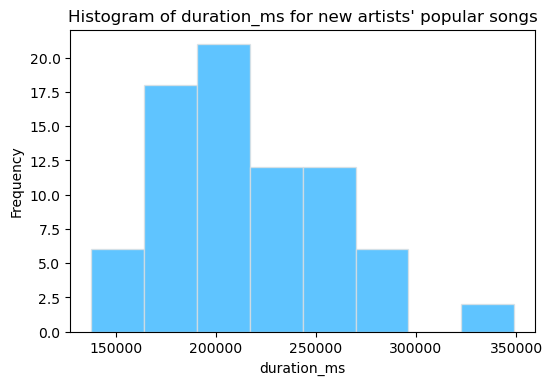

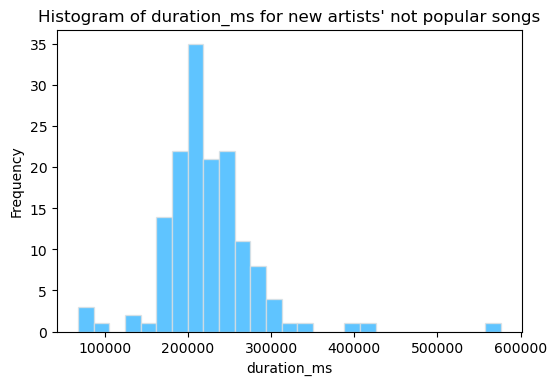

Since p value = 0.0167 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


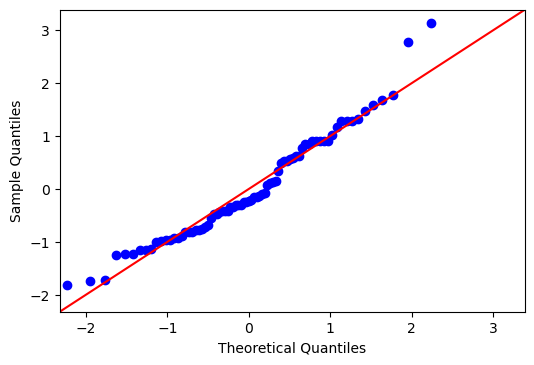

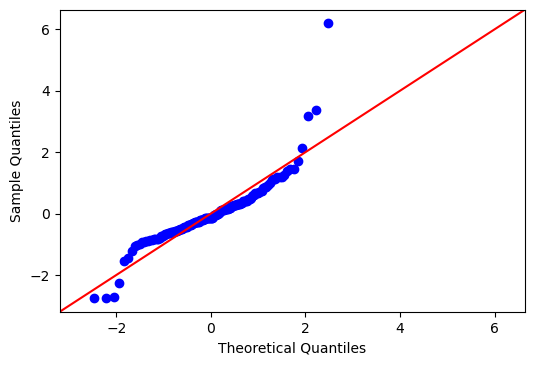

In [ ]:
targetCol = 'duration_ms'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the left of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup, greater = 0)

H0: The locations of duration_ms for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of duration_ms for 2018-2021 臺灣新人歌手的熱門歌曲 is to the left of the location of duration_ms for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.0532 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, duration_ms may not be a factor that affects the music popularity of new artists.


#### (10) artist_followers

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

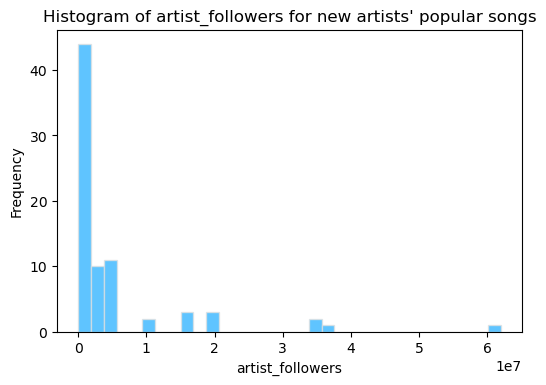

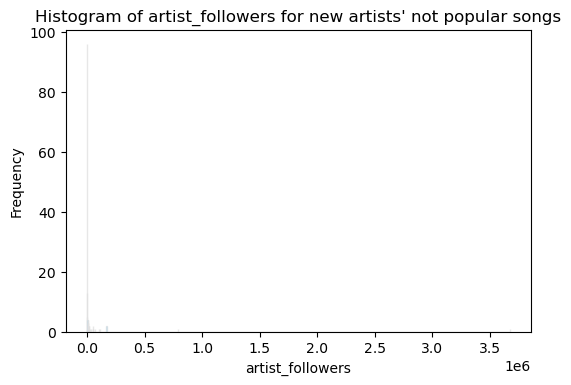

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


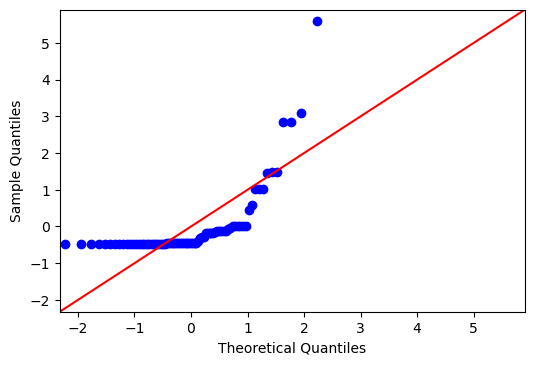

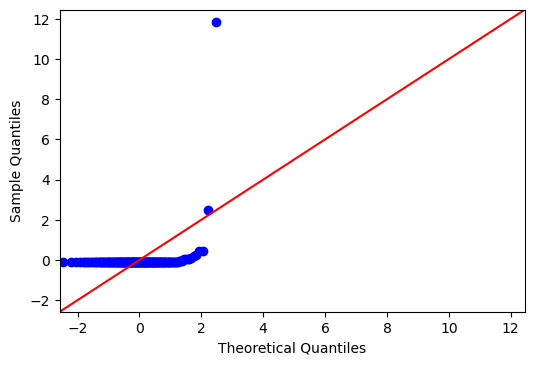

In [ ]:
targetCol = 'artist_followers'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')

plt.show()
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of artist_followers for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of artist_followers for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of artist_followers for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of artist_followers for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of artist_followers for 2018-2021 臺灣新人歌手的非熱門歌曲.
Therefore, artist_followers may be a factor that affects the music popularity of new artists.


#### (11) artist_popularity

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

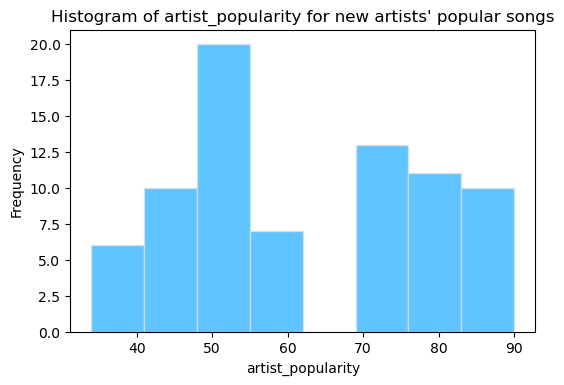

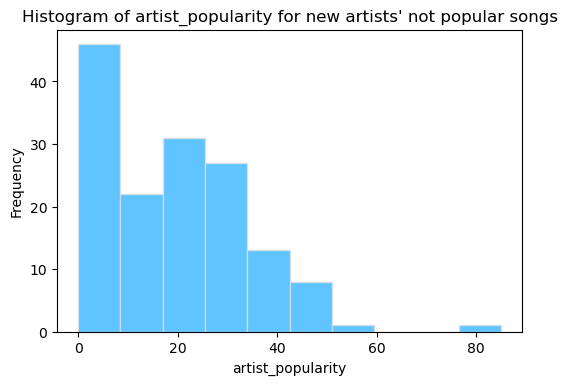

Since p value = 0.0002 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


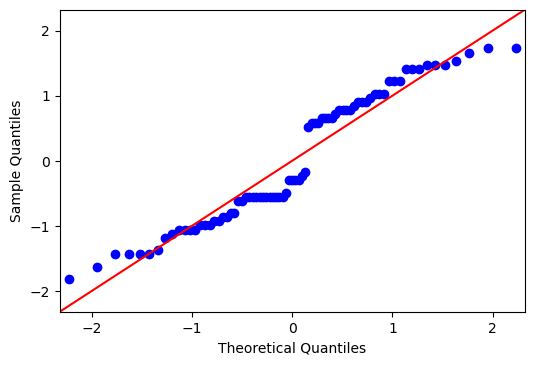

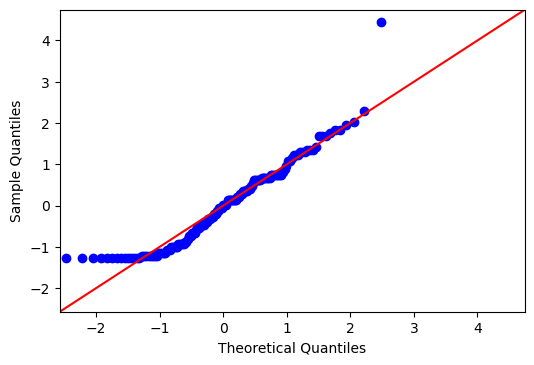

In [ ]:
targetCol = 'artist_popularity'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of artist_popularity for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of artist_popularity for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of artist_popularity for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of artist_popularity for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of artist_popularity for 2018-2021 臺灣新人歌手的非熱門歌曲.
Therefore, artist_popularity may be a factor that affects the music popularity of new artists.


#### (12) experience

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

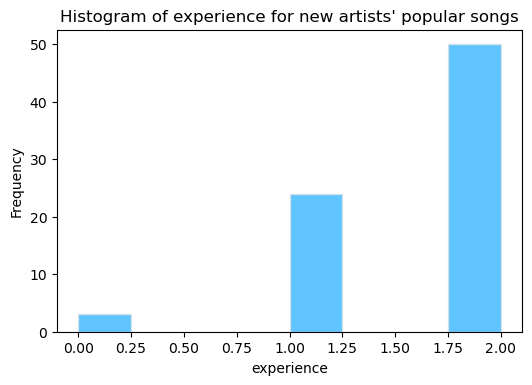

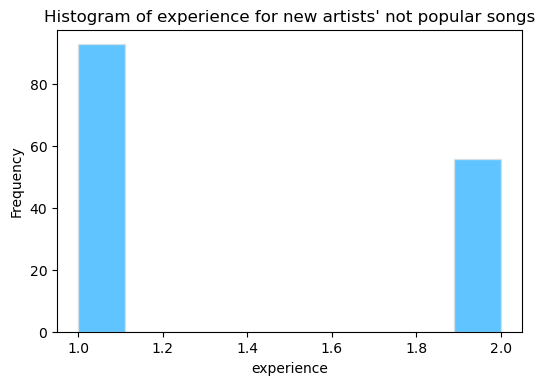

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


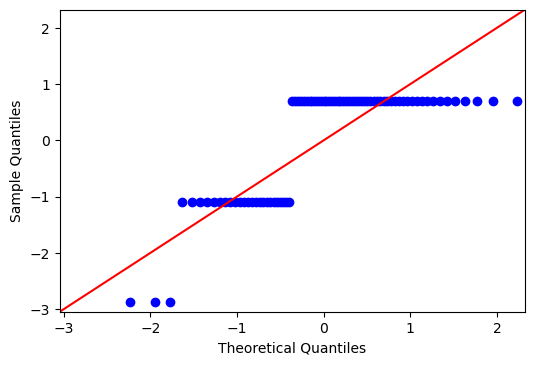

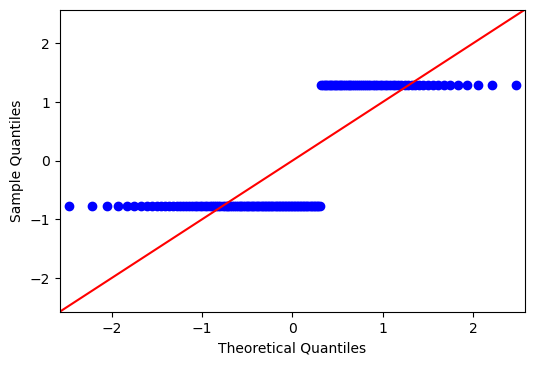

In [ ]:
targetCol = 'experience'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣新人歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of experience for 2018-2021 臺灣新人歌手的熱門歌曲、2018-2021 臺灣新人歌手的非熱門歌曲 are the same
H1: The location of experience for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of experience for 2018-2021 臺灣新人歌手的非熱門歌曲 

Since p value = 0.0002 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of experience for 2018-2021 臺灣新人歌手的熱門歌曲 is to the right of the location of experience for 2018-2021 臺灣新人歌手的非熱門歌曲.
Therefore, experience may be a factor that affects the music popularity of new artists.


#### (13) 是否為電視劇或電影配樂

let $p_1$ be the proportion of popular songs from new artists which are music of dramas or movies <br/>
let $p_2$ be the proportion of not popular songs from new artists which are music of dramas or movies 

let H0 : $p_1$ - $p_2$ = 0 <br/>
let H1 : $p_1$ - $p_2$ $\neq$ 0

apply central limit theorem when nonnormal ref: https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/z-test/

In [ ]:
targetCol = 'drama_movie'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

samp1 = popular
samp2 = notPopular

p1 = samp1.mean()
p2 = samp2.mean()
num1 = samp1.shape[0]
num2 = samp2.shape[0]
samp12 = np.concatenate([samp1, samp2])
p_pool = samp12.mean()

print("check required condition:")
print("num1 * p1 = {}, num1 * (1 - p1) = {}".format(num1 * p1, num1 * (1 - p1)))
print("num2 * p2 = {}, num2 * (1 - p2) = {}".format(num2 * p2, num2 * (1 - p2)))
print("they're not all >= 5 \n")
print('num1 =', num1)
print('num2 =', num2)
print('Since the number of both samples are > 30, by central limit theorem, we can view the distribution as normal and apply z-test.')

std_p_pool = (p_pool * (1 - p_pool) * (1 / num1 + 1 / num2)) ** 0.5
z_value = (p1 - p2) / std_p_pool

# two tail
p_value = 1 - stats.norm.cdf(z_value)
if p_value > 0.5:
    p_value = (1 - p_value) * 2
else:
    p_value =  p_value * 2
print(f"p-value = {p_value:.4f}")

check required condition:
num1 * p1 = 1.0, num1 * (1 - p1) = 76.0
num2 * p2 = 8.0, num2 * (1 - p2) = 141.0
they're not all >= 5 

num1 = 77
num2 = 149
Since the number of both samples are > 30, by central limit theorem, we can view the distribution as normal and apply z-test.
p-value = 0.1380


Since p value = 0.1380 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that $p_1 = p_2$. <br>
Therefore, whether it's drama or movie music may not be a factor that affects the music popularity of new artists.

#### Conclusion - 新人歌手的熱門 / 非熱門音樂在各項變數的分布
According to the tests, the locations of the following factors for popular songs from new artists and not popular songs from new artists are not the same.
* danceability
* loudness
* artist_followers
* artist_popularity
* experience (年資)

As a result, they are the relatively important factors that affect the music popularity of new artists, while energy, key, acousticness, liveness, valence, tempo, duration_ms, 是否為電視劇或電影配樂 probably don't affect the music popularity of new artists. 

從上述可知，關於 danceability 和 loudness 兩個和音樂本身較相關的因素，假設檢定結果皆顯示，新人歌手熱門音樂的這兩個變數之分布 都比 新人歌手非熱門音樂的這兩個變數之分布 靠右邊，因此可見新人歌手熱門音樂的歌曲律動性較大、歌曲音量較大。希望提高音樂熱門程度的新人歌手或許可以從這兩個方向著手，思考如何實踐對音樂的想法的同時，也做出能吸引大眾的歌曲。

關於 artists_followers、artist_popularity 和 experience 三個和歌手本身較相關的因素，假設檢定結果皆顯示，新人歌手熱門音樂的這三個變數之分布 都比 新人歌手非熱門音樂的這三個變數之分布 靠右邊，因此可見歌曲上熱門音樂榜的新人歌手的 follower (追蹤者/忠實粉絲)、popularity (忠實粉絲 + 路人粉絲)、experience (年資) 都較大，我們也由此得知，音樂熱門程度跟歌手本身還是有關係。或許「新人音樂熱門程度除了取決於音樂的特性之外，還和歌手的人氣相關」的推論，會讓音樂有實力但自身人氣不佳的歌手感到無奈，自己還是需要經營音樂以外的事情，提升人氣才能被看見，但我們也發現新人音樂熱門程度和歌手的年資相關，此推論或許可以為其音樂仍沒沒無聞的歌手帶來一些希望，代表歌手在音樂產業中的長期耕耘、累積經驗對提升音樂熱門程度是有幫助的。

#### 2. 看新人熱門歌曲的常見 genre，以更了解資料集的特性

common genres in popular songs from new artists


,genres,count,prob
4,mandopop,25,0.128866
1,pop,22,0.113402
21,taiwan pop,21,0.108247
9,taiwan hip hop,15,0.077320
0,dance pop,15,0.077320
5,electropop,10,0.051546
33,chinese viral pop,10,0.051546
3,mainland chinese pop,7,0.036082
20,taiwan indie,7,0.036082
6,post-teen pop,5,0.025773


,genres,prob
0,mandopop,0.128866
1,pop,0.113402
2,taiwan pop,0.108247
3,taiwan hip hop,0.077320
4,dance pop,0.077320
5,others,0.494845


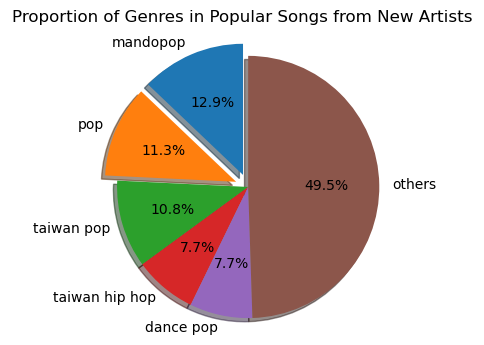

In [ ]:
targetCol = 'genres'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

p = []
for i, element in enumerate(popular):
    element = element.strip('[')
    element = element.strip(']')
    element = element.strip("'").split("', '")
    p = p + element
df_genres_p = pd.DataFrame({'genres': list(Counter(p).keys()), 'count': list(Counter(p).values())})
df_genres_p['prob'] = df_genres_p['count'] / len(p)
df_genres_p = df_genres_p.sort_values(by=['prob'], ascending=False)
print('common genres in popular songs from new artists')
display(df_genres_p)

df_pieChart = pd.DataFrame({'genres': df_genres_p.iloc[:5]['genres'], 'prob': df_genres_p.iloc[:5]['prob']})
row = {'genres': 'others', 'prob': sum(df_genres_p.iloc[5:]['prob'])}
df_pieChart = df_pieChart.append(row, ignore_index=True)
display(df_pieChart)

sizes = df_pieChart["prob"]
labels = df_pieChart["genres"]

fig1, ax1 = plt.subplots()        

explode = (0.1, 0.1, 0, 0, 0, 0)     # 代表第一、二塊要分開
ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
ax1.axis("equal")                 # 確保畫出來會是個圓形
plt.title("Proportion of Genres in Popular Songs from New Artists")
plt.show()

# interpretation
# relative frequency

#### Conclusion - 新人熱門歌曲的常見 genre
According to the table, we can see that the top 5 common genres in popular songs from new artists are
* mandpop
* pop
* taiwan pop
* taiwan hip hop
* dance pop

Therefore, we can know that genres related to 'pop' is very common in popular songs from new artists, and it even occupies almost half of the proportion. Surprisingly, 'taiwan hip hop' is a common genre. 此狀況符合近年來臺灣嘻哈音樂興起的現象，也可見即使流行音樂目前仍為主流，觀眾也漸漸開始願意接受其他的音樂風格。由此可知，若是想要提升音樂熱門程度的新人歌手，建議可以從目前的主流風格 - 流行音樂下手，但較偏好其他非主流風格的新人歌手也不必強迫自己改變，仍然可以嘗試創新，因為從資料我們可以推測觀眾並不是完全無法接受新興的風格。

#### 五、成熟歌手的熱門 / 非熱門音樂
#### 1. 成熟歌手的熱門 / 非熱門音樂在各項變數的分布
* 變數共有 danceability、energy、key、loudness、acousticness、liveness、valence、tempo、duration_ms、artist_followers、artist_popularity、experience、是否為電視劇或電影配樂，共 13 項變數
* 探討成熟歌手的熱門音樂在該項變數的分布 vs. 成熟歌手的非熱門音樂在該項變數的分布 有何不同

In [ ]:
targetGroup = 'old'
pop1 = '2018-2021 臺灣成熟歌手的熱門歌曲'
pop2 = '2018-2021 臺灣成熟歌手的非熱門歌曲'
df_p = taiwan_popular_old
df_np = taiwan_notPopular_old

#### (1) danceability

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

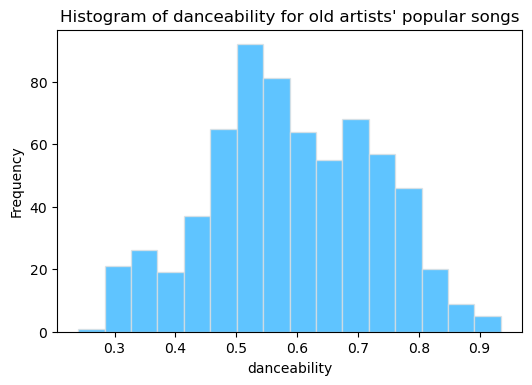

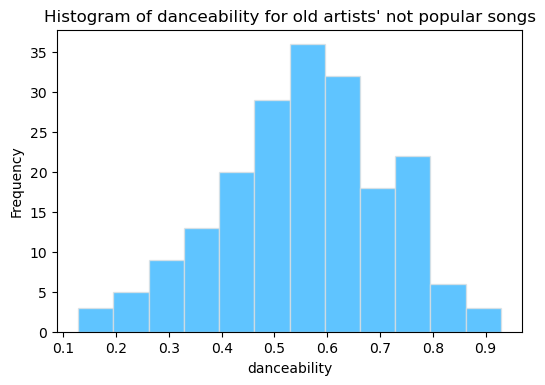

Since p value = 0.0001 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.3992 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution is normal.


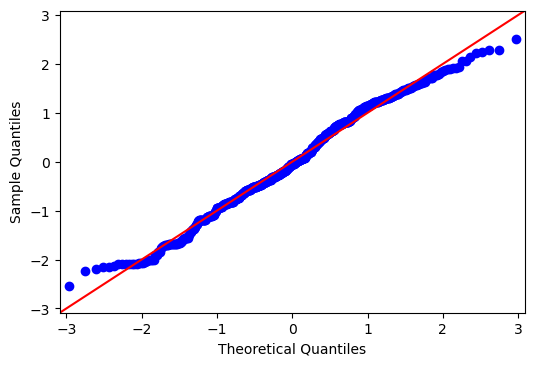

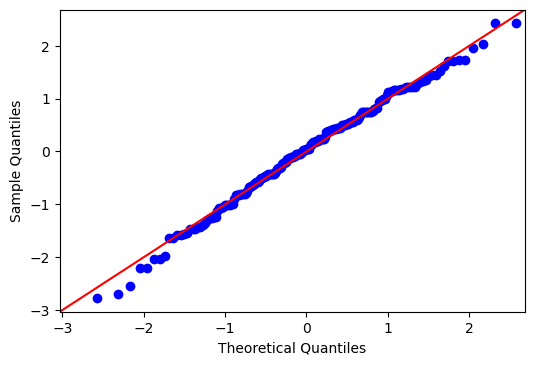

In [ ]:
targetCol = 'danceability'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

According to the results from Shapiro test, we can infer at 5% significance level that the distribution isn't normal. So we should apply wilcoxon rank sum test.

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of danceability for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of danceability for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of danceability for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0060 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of danceability for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of danceability for 2018-2021 臺灣成熟歌手的非熱門歌曲.
Therefore, danceability may be a factor that affects the music popularity of old artists.


#### (2) energy

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

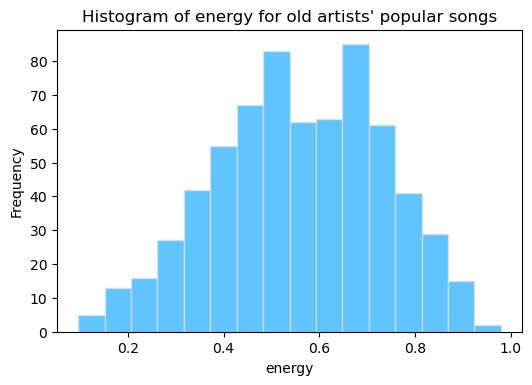

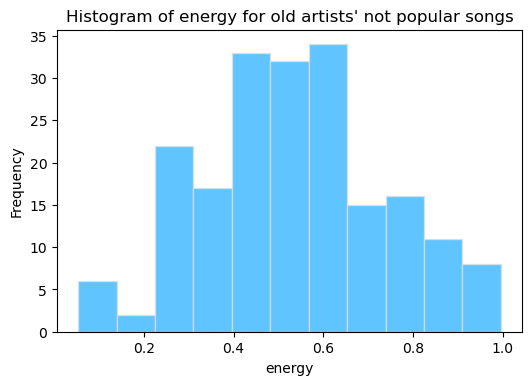

Since p value = 0.0003 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.1309 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution is normal.


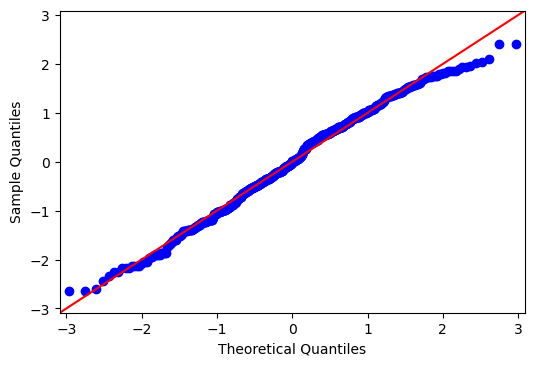

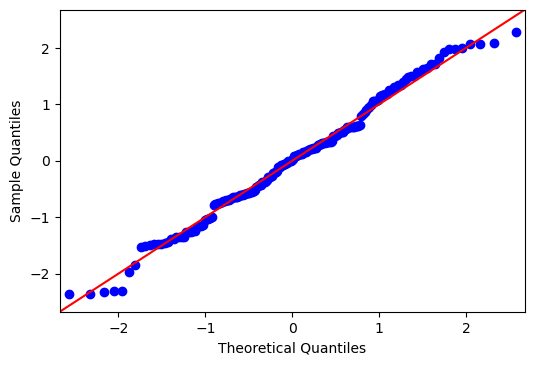

In [ ]:
targetCol = 'energy'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

According to the results from Shapiro test, we can infer at 5% significance level that the distribution is not normal. So we should apply Wilcoxon Rank Sum Test.

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of energy for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of energy for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of energy for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0382 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of energy for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of energy for 2018-2021 臺灣成熟歌手的非熱門歌曲.
Therefore, energy may be a factor that affects the music popularity of old artists.


#### (3) key

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

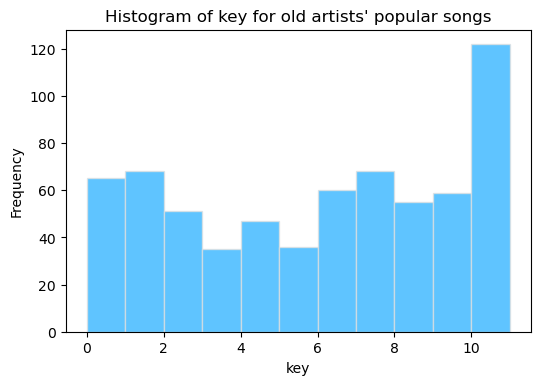

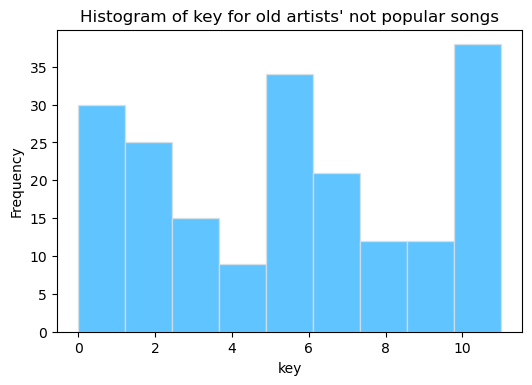

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


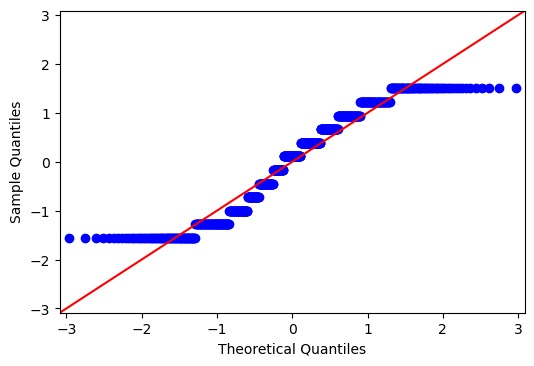

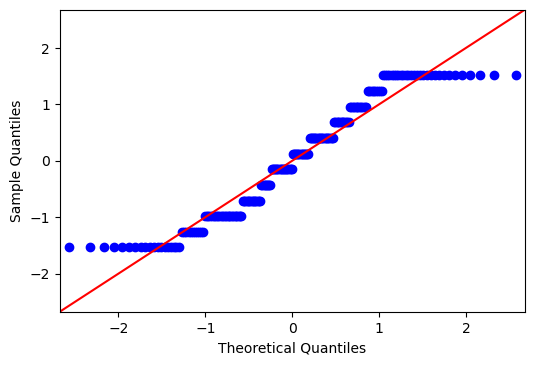

In [ ]:
targetCol = 'key'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

According to the results from Shapiro test, we can infer at 5% significance level that the distribution isn't normal. So we should apply wilcoxon rank sum test.

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of key for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of key for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of key for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.4356 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, key may not be a factor that affects the music popularity of old artists.


#### (4) loudness

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

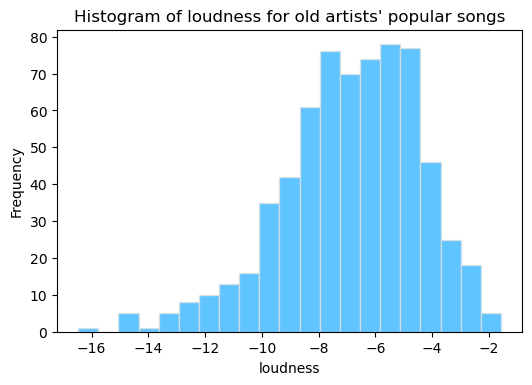

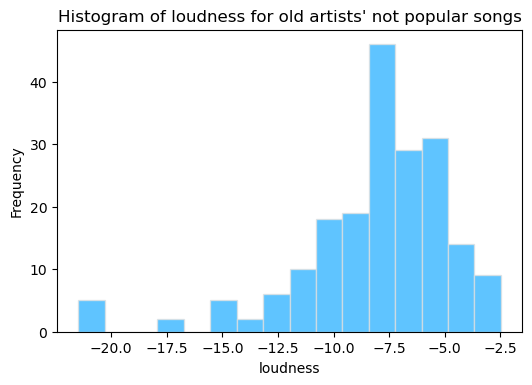

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


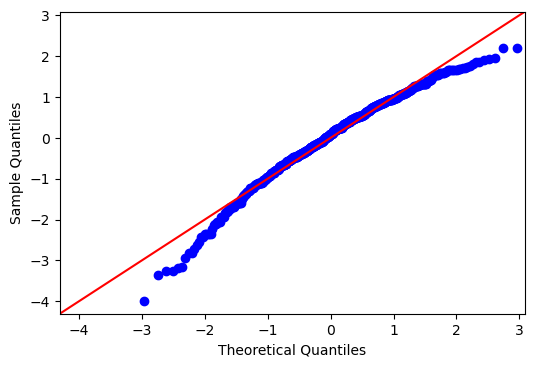

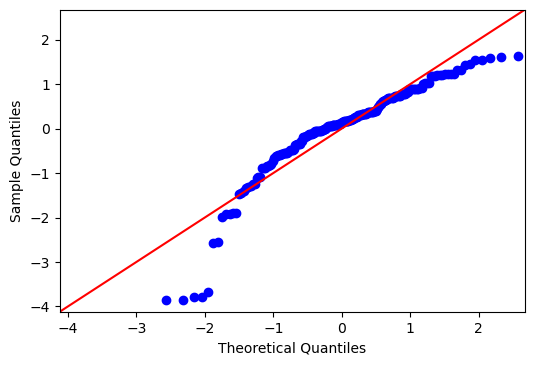

In [ ]:
targetCol = 'loudness'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of loudness for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of loudness for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of loudness for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of loudness for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of loudness for 2018-2021 臺灣成熟歌手的非熱門歌曲.
Therefore, loudness may be a factor that affects the music popularity of old artists.


#### (5) acousticness

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

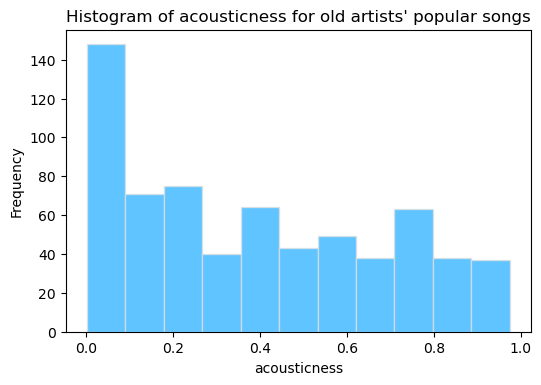

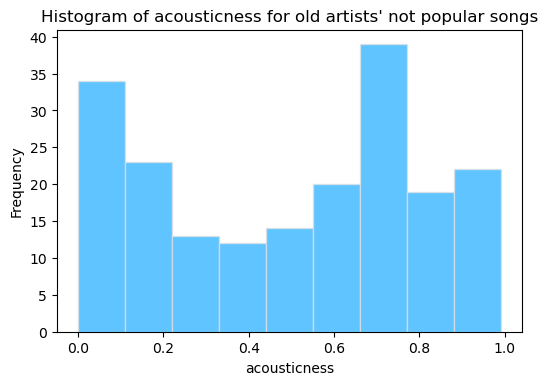

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


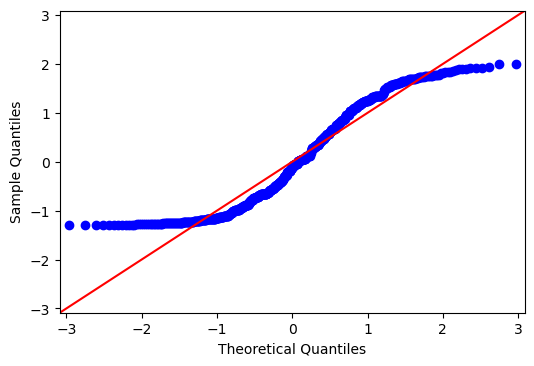

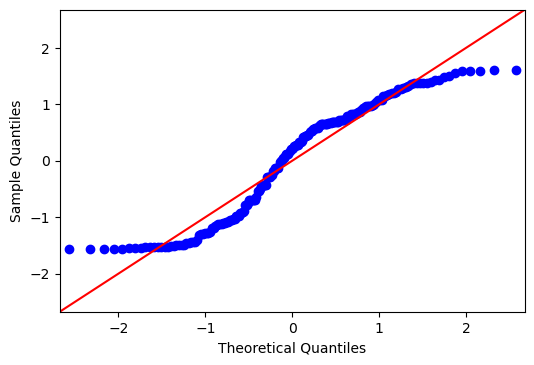

In [ ]:
targetCol = 'acousticness'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the left of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup, greater = 0)

H0: The locations of acousticness for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of acousticness for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the left of the location of acousticness for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0001 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of acousticness for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the left of the location of acousticness for 2018-2021 臺灣成熟歌手的非熱門歌曲.
Therefore, acousticness may be a factor that affects the music popularity of old artists.


#### (6) liveness

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

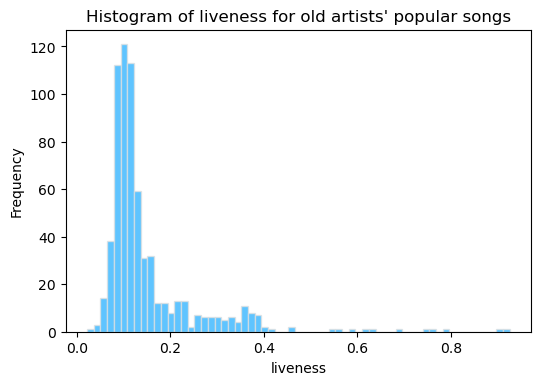

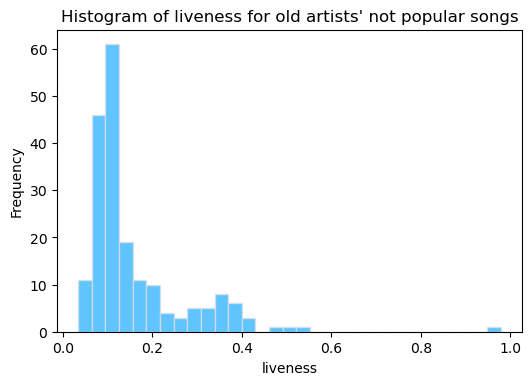

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


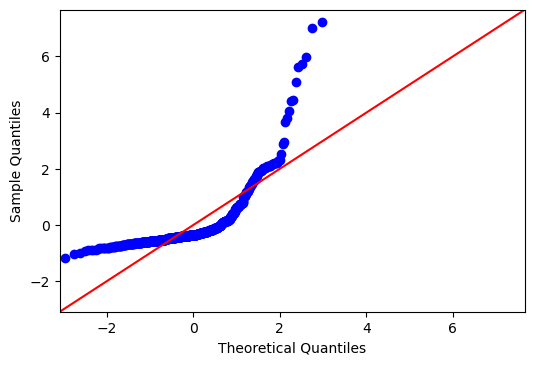

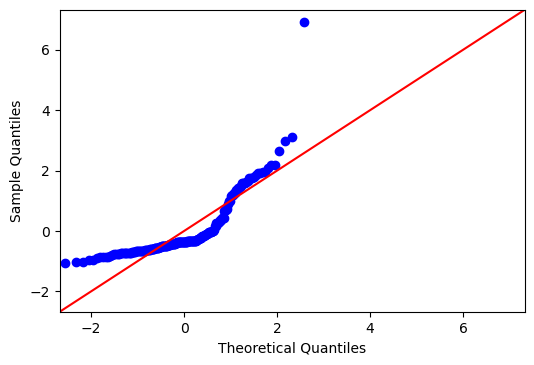

In [ ]:
targetCol = 'liveness'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of liveness for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of liveness for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of liveness for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.7271 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, liveness may not be a factor that affects the music popularity of old artists.


#### (7) valence

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

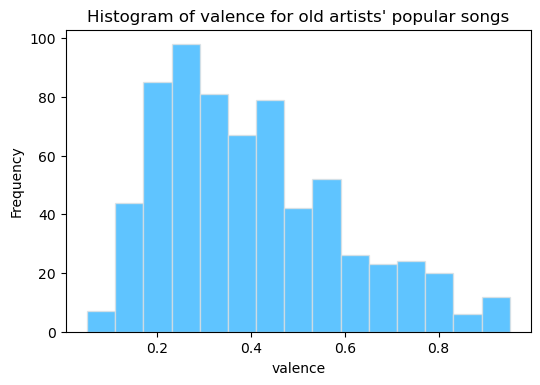

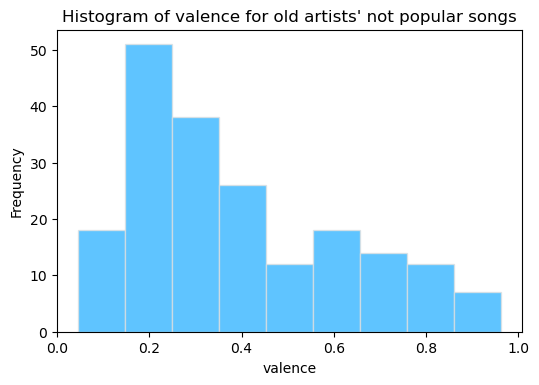

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


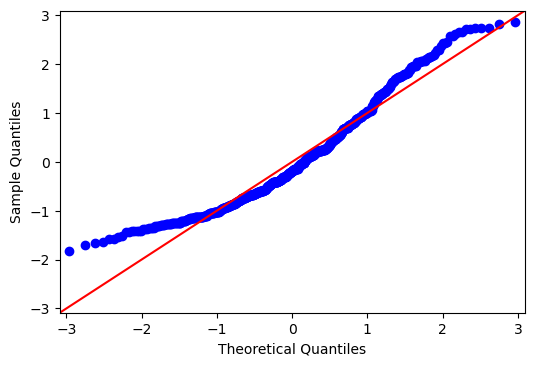

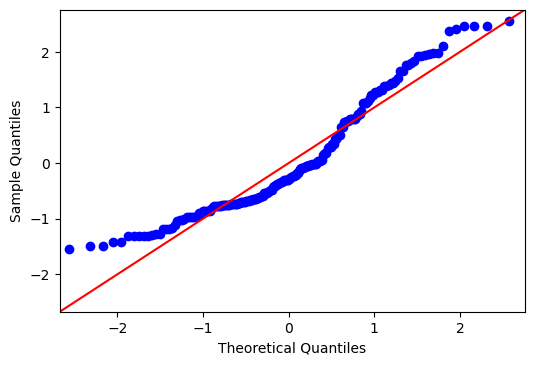

In [ ]:
targetCol = 'valence'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of valence for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of valence for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of valence for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0619 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, valence may not be a factor that affects the music popularity of old artists.


#### (8) tempo

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

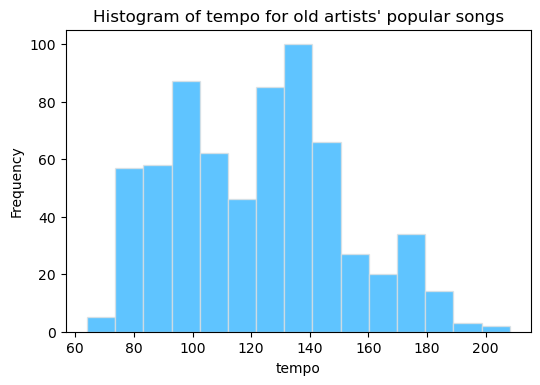

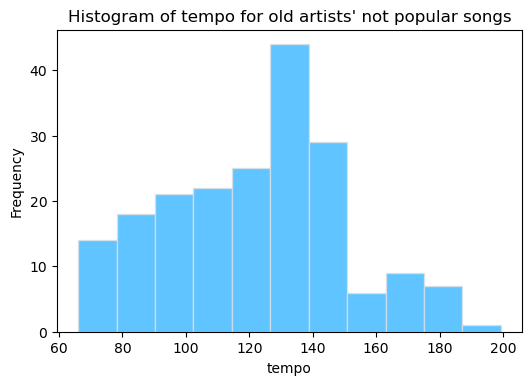

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0030 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


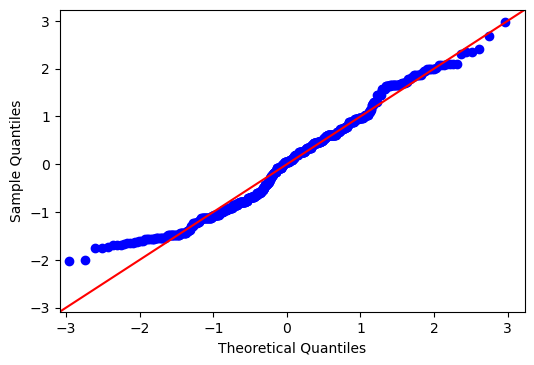

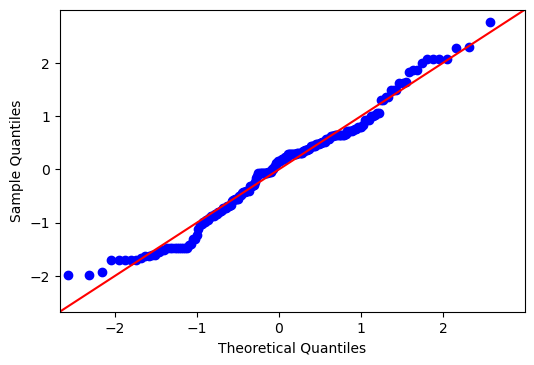

In [ ]:
targetCol = 'tempo'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the left of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup, greater = 0)

H0: The locations of tempo for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of tempo for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the left of the location of tempo for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.5904 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, tempo may not be a factor that affects the music popularity of old artists.


#### (9) duration_ms

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

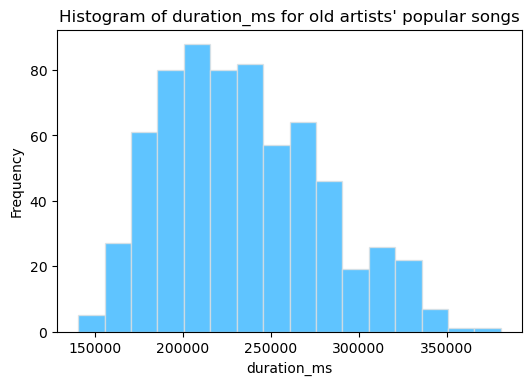

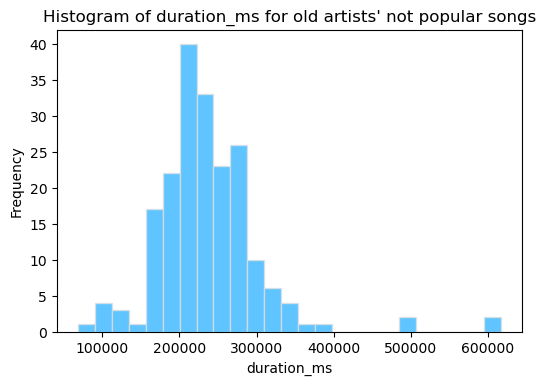

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


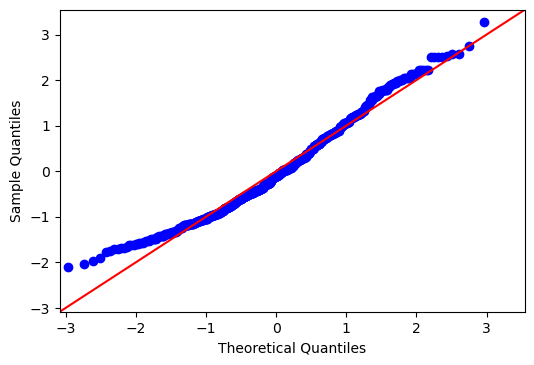

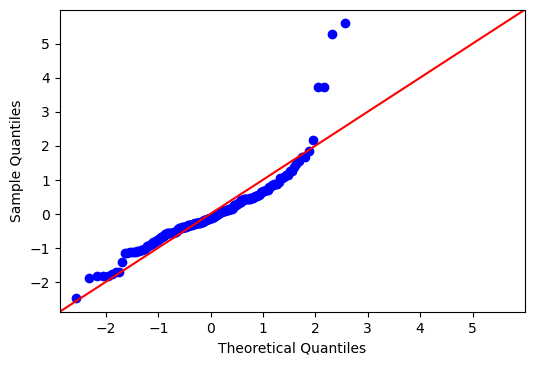

In [ ]:
targetCol = 'duration_ms'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the left of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup, greater = 0)

H0: The locations of duration_ms for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of duration_ms for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the left of the location of duration_ms for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.4825 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the locations are the same.
Therefore, duration_ms may not be a factor that affects the music popularity of old artists.


#### (10) artist_followers

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

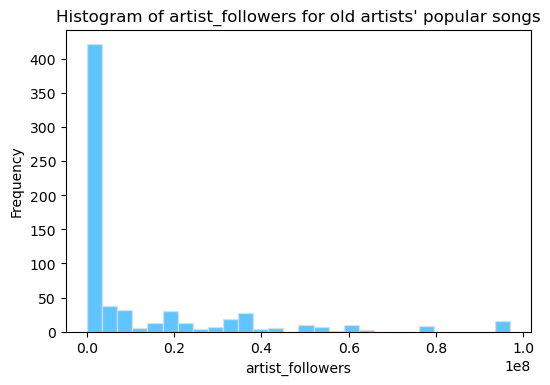

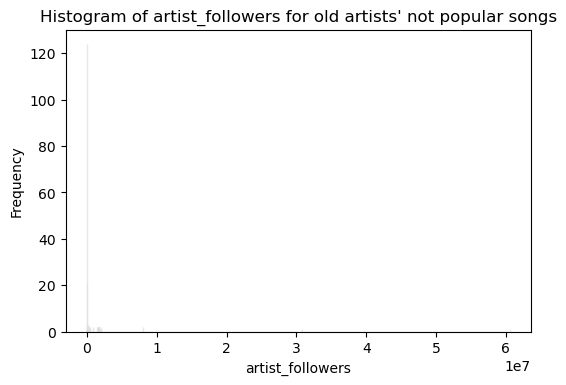

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


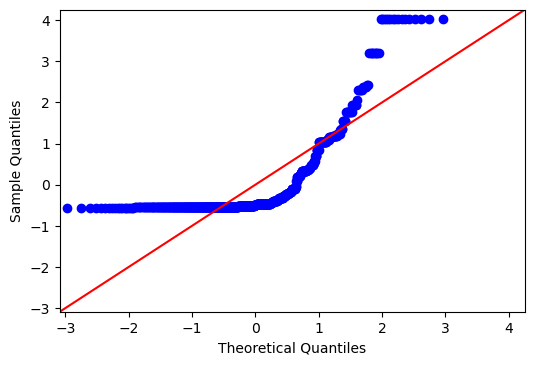

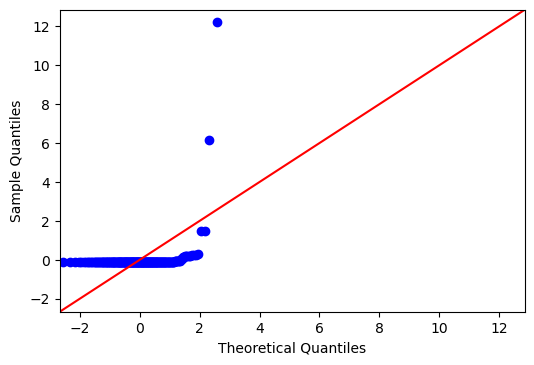

In [ ]:
targetCol = 'artist_followers'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')

plt.show()
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of artist_followers for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of artist_followers for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of artist_followers for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of artist_followers for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of artist_followers for 2018-2021 臺灣成熟歌手的非熱門歌曲.
Therefore, artist_followers may be a factor that affects the music popularity of old artists.


#### (11) artist_popularity

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

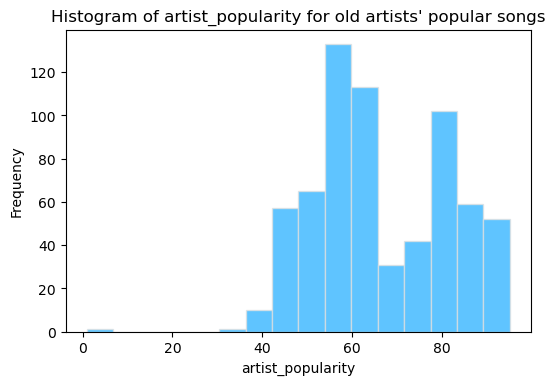

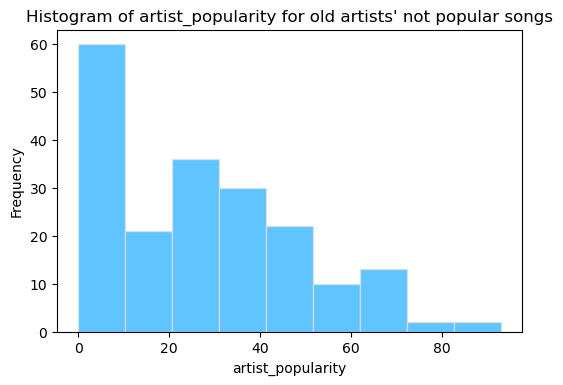

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


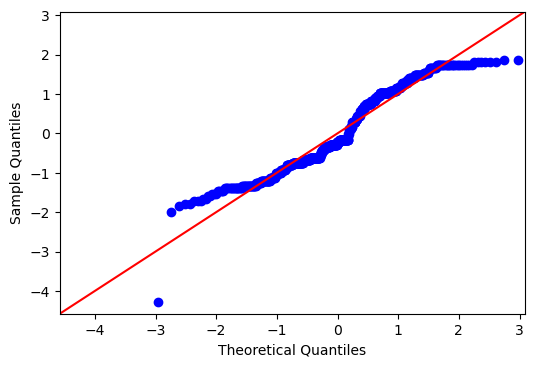

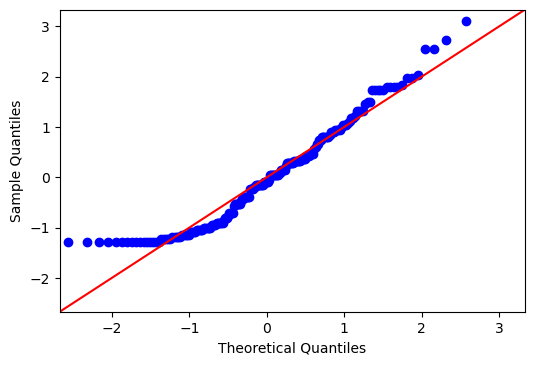

In [ ]:
targetCol = 'artist_popularity'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of artist_popularity for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of artist_popularity for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of artist_popularity for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of artist_popularity for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of artist_popularity for 2018-2021 臺灣成熟歌手的非熱門歌曲.
Therefore, artist_popularity may be a factor that affects the music popularity of old artists.


#### (12) experience

#### First, check whether the distribution is normal by histogram, qq plot and Shapiro test

##### [ Shapiro-wilk test ]
H0: The distribution is normal <br/>
H1: The distribution is not normal

apply Shapiro test

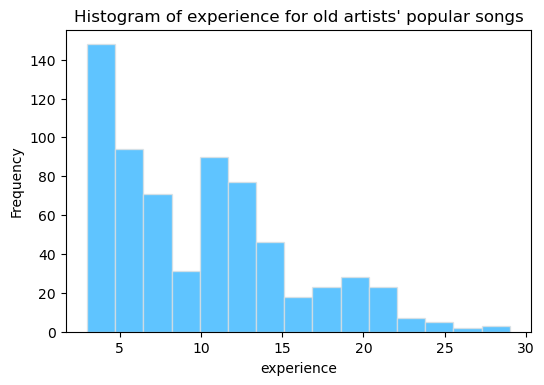

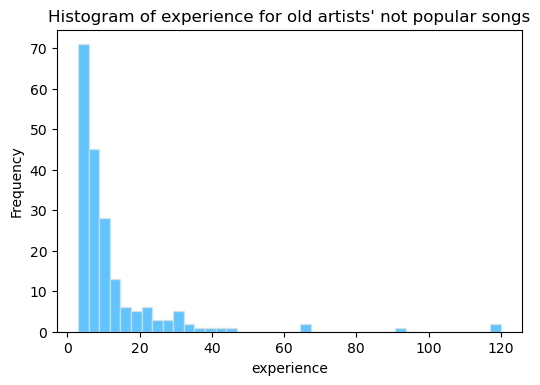

Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.
Since p value = 0.0000 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution isn't normal.


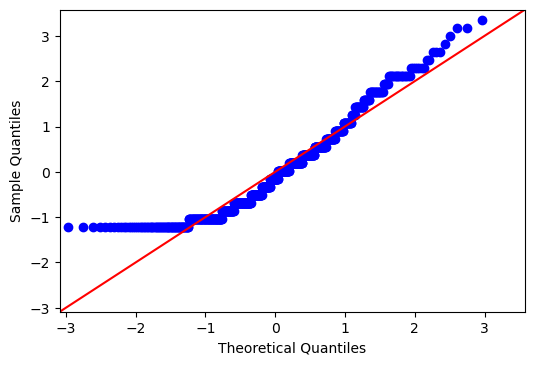

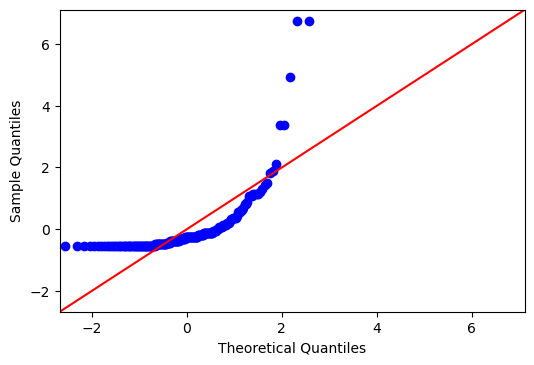

In [ ]:
targetCol = 'experience'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

# Check Normality Assumption
histogram(popular, targetCol, targetGroup, 'popular')
histogram(notPopular, targetCol, targetGroup, 'not popular')
qqplot(popular)
qqplot(notPopular)
shapiro(popular)
shapiro(notPopular)

#### check required conditions
1. two populations with independent samples
2. ordinal or interval data

All required conditions are met, and the sample sizes are all > 10, so we can apply wilcoxon rank sum test.

In [ ]:
print('H0: The locations of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same')
print('H1: The location of', targetCol, 'for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of', targetCol,'for 2018-2021 臺灣成熟歌手的非熱門歌曲 \n')

wilcoxonRankSumTest(popular, notPopular, targetCol, pop1, pop2, targetGroup)

H0: The locations of experience for 2018-2021 臺灣成熟歌手的熱門歌曲、2018-2021 臺灣成熟歌手的非熱門歌曲 are the same
H1: The location of experience for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of experience for 2018-2021 臺灣成熟歌手的非熱門歌曲 

Since p value = 0.0065 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the location of experience for 2018-2021 臺灣成熟歌手的熱門歌曲 is to the right of the location of experience for 2018-2021 臺灣成熟歌手的非熱門歌曲.
Therefore, experience may be a factor that affects the music popularity of old artists.


#### (13) 是否為電視劇或電影配樂

let $p_1$ be the proportion of popular songs from new artists which are music of dramas or movies <br/>
let $p_2$ be the proportion of not popular songs from new artists which are music of dramas or movies 

let H0 : $p_1$ - $p_2$ = 0 <br/>
let H1 : $p_1$ - $p_2$ $\neq$ 0

apply central limit theorem when nonnormal ref: https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/z-test/

In [ ]:
targetCol = 'drama_movie'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

samp1 = popular
samp2 = notPopular

p1 = samp1.mean()
p2 = samp2.mean()
num1 = samp1.shape[0]
num2 = samp2.shape[0]
samp12 = np.concatenate([samp1, samp2])
p_pool = samp12.mean()

print("check required condition:")
print("num1 * p1 = {}, num1 * (1 - p1) = {}".format(num1 * p1, num1 * (1 - p1)))
print("num2 * p2 = {}, num2 * (1 - p2) = {}".format(num2 * p2, num2 * (1 - p2)))
print('Since they are all > 5, we can view the distribution as normal and apply z-test.')

std_p_pool = (p_pool * (1 - p_pool) * (1 / num1 + 1 / num2)) ** 0.5
z_value = (p1 - p2) / std_p_pool

# two tail
p_value = 1 - stats.norm.cdf(z_value)
if p_value > 0.5:
    p_value = (1 - p_value) * 2
else:
    p_value =  p_value * 2
print(f"p-value = {p_value:.4f}")

check required condition:
num1 * p1 = 57.99999999999999, num1 * (1 - p1) = 608.0
num2 * p2 = 13.0, num2 * (1 - p2) = 183.0
Since they are all > 5, we can view the distribution as normal and apply z-test.
p-value = 0.3528


Since p value = 0.3528 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that $p_1 = p_2$. <br>
Therefore, whether it's drama or movie music may not be a factor that affects the music popularity of old artists.

#### Conclusion - 成熟歌手的熱門 / 非熱門音樂在各項變數的分布
According to the tests, the locations of the following factors for popular songs from old artists and not popular songs from old artists are not the same.
* danceability
* energy
* loudness
* acousticness
* artist_followers
* artist_popularity
* experience (年資)

As a result, they are the relatively important factors that affect the music popularity of old artists, while key, liveness, valence, tempo, duration_ms, 是否為電視劇或電影配樂 probably don't affect the music popularity of old artists.

可能影響成熟歌手歌曲熱門程度的因素與新人歌手大致相同，只有 energy、acousticness 是成熟歌手才有的因素。關於 danceability、loudness、energy、acousticness 四個和音樂本身較相關的因素，假設檢定結果皆顯示，成熟歌手熱門音樂的這四個變數之分布 都比 成熟歌手非熱門音樂的這四個變數之分布 靠右邊，因此可見成熟歌手熱門音樂的歌曲律動性較大、歌曲音量較大、歌曲活力較大、歌曲使用非電子樂器的程度越高。關於 artists_followers、artist_popularity 和 experience 三個和歌手本身較相關的因素，假設檢定結果皆顯示，新人歌手熱門音樂的這三個變數之分布 都比 新人歌手非熱門音樂的這三個變數之分布 靠右邊，因此可見歌曲上熱門音樂榜的新人歌手的 follower (追蹤者/忠實粉絲)、popularity (忠實粉絲 + 路人粉絲)、experience (年資) 都較大，我們也由此得知，音樂熱門程度跟歌手本身還是有正相關。

#### Conclusion - 成熟歌手的熱門 / 非熱門音樂在各項變數的分布 vs. 新人歌手的熱門 / 非熱門音樂在各項變數的分布
可能影響音樂熱門程度的因素分別是 <br>
成熟歌手：danceability, energy, loudness, acousticness, artist_followers, artist_popularity, experience <br>
新人歌手：danceability, loudness, artist_followers, artist_popularity, experience <br>

比較成熟歌手與新人歌手歌曲熱門程度因素之後我們發現，energy、acousticness 並非可能影響新人歌手歌曲熱門程度的因素，代表對新人歌手的歌曲而言，不一定要刻意讓活力大、使用非電子樂器的程度高，才能讓歌曲變得更熱門。我們推測是因為...(想不到原因 需要討論)

#### 2. 看成熟歌手熱門歌曲的常見 genre，以更了解資料集的特性

common genres in popular songs from old artists


,genres,count,prob
0,mandopop,356,0.178446
2,pop,208,0.104261
1,taiwan pop,207,0.103759
4,dance pop,136,0.068170
18,taiwan singer-songwriter,68,0.034085
...,...,...,...
85,vapor pop,1,0.000501
86,escape room,1,0.000501
87,minnesota hip hop,1,0.000501
88,trap queen,1,0.000501


,genres,prob
0,mandopop,0.178446
1,pop,0.104261
2,taiwan pop,0.103759
3,dance pop,0.068170
4,taiwan singer-songwriter,0.034085
5,others,0.511278


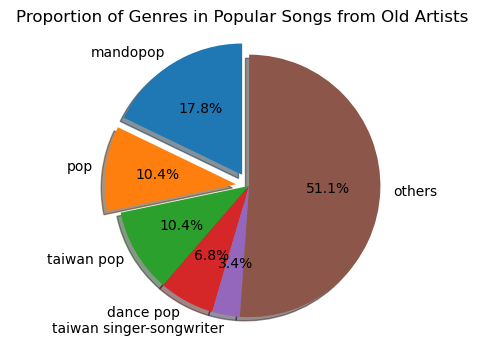

In [ ]:
targetCol = 'genres'
popular = df_p[targetCol]
notPopular = df_np[targetCol]

p = []
for i, element in enumerate(popular):
    element = element.strip('[')
    element = element.strip(']')
    element = element.strip("'").split("', '")
    p = p + element
df_genres_p = pd.DataFrame({'genres': list(Counter(p).keys()), 'count': list(Counter(p).values())})
df_genres_p['prob'] = df_genres_p['count'] / len(p)
df_genres_p = df_genres_p.sort_values(by=['prob'], ascending=False)
print('common genres in popular songs from old artists')
display(df_genres_p)

df_pieChart = pd.DataFrame({'genres': df_genres_p.iloc[:5]['genres'], 'prob': df_genres_p.iloc[:5]['prob']})
row = {'genres': 'others', 'prob': sum(df_genres_p.iloc[5:]['prob'])}
df_pieChart = df_pieChart.append(row, ignore_index=True)
display(df_pieChart)

sizes = df_pieChart["prob"]
labels = df_pieChart["genres"]

fig1, ax1 = plt.subplots()        

explode = (0.1, 0.1, 0, 0, 0, 0)     # 代表第一、二塊要分開
ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
ax1.axis("equal")                 # 確保畫出來會是個圓形
plt.title("Proportion of Genres in Popular Songs from Old Artists")
plt.show()

# interpretation
# relative frequency

#### Conclusion - 成熟歌手熱門歌曲的常見 genre
According to the table, we can see that the top 5 common genres in popular songs from old artists are
* mandpop
* pop
* taiwan pop
* dance pop
* taiwan singer-songwriter

Therefore, we can know that genres related to 'pop' is very common in popular songs from old artists, and it even occupies almost half of the proportion, which is similar to the result of new artists. Surprisingly, 'taiwan singer-songwriter'(創作歌手) is a common genre.

-------------------------------------

#### 六、歌曲有上熱門音樂榜的新人/成熟歌手的 poplularity（忠實粉絲 + 路人粉絲） vs. followers（忠實粉絲）的關係

#### 1. 歌曲有上熱門音樂榜的新人歌手的 poplularity（忠實粉絲 + 路人粉絲） vs. followers（忠實粉絲）的關係

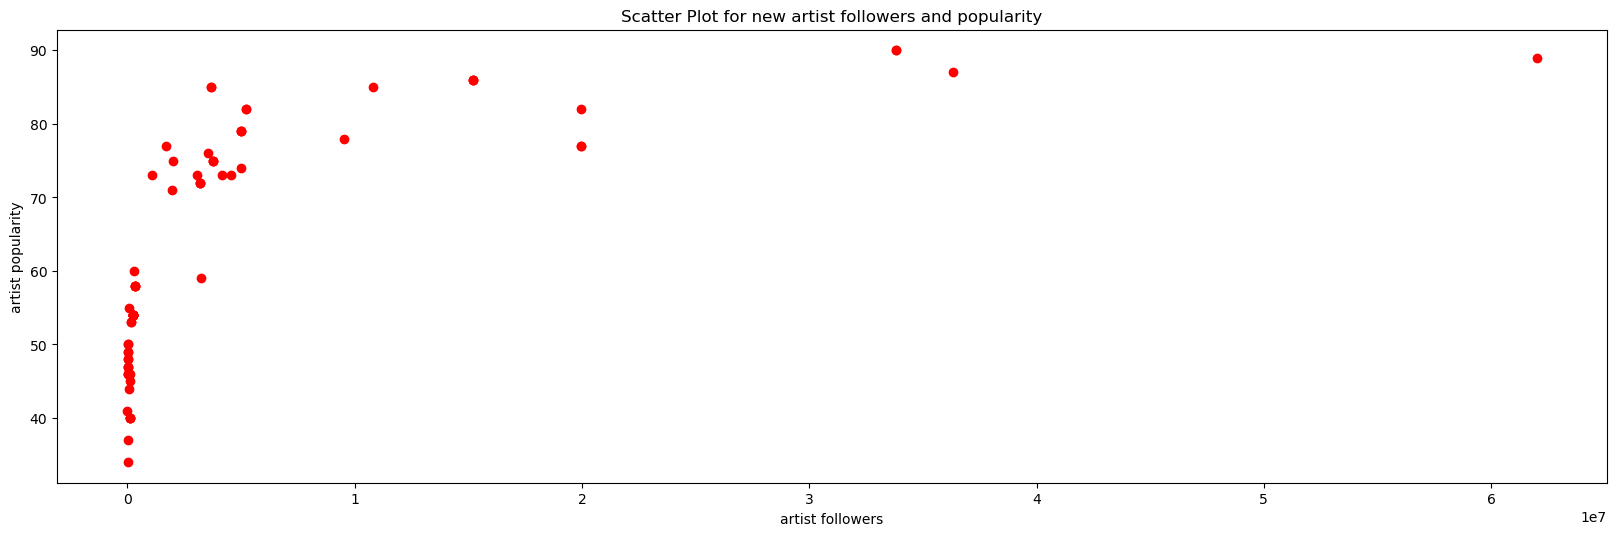

In [ ]:
# 方法 2 - 有趨勢線
plt.figure(figsize=(20, 6))
plt.scatter(taiwan_popular_new["artist_followers"], taiwan_popular_new["artist_popularity"], color="r")
plt.title("Scatter Plot for new artist followers and popularity")
plt.xlabel("artist followers")
plt.ylabel("artist popularity")
plt.show()

#### 2. 歌曲有上熱門音樂榜的成熟歌手的 poplularity（忠實粉絲 + 路人粉絲） vs. followers（忠實粉絲）的關係

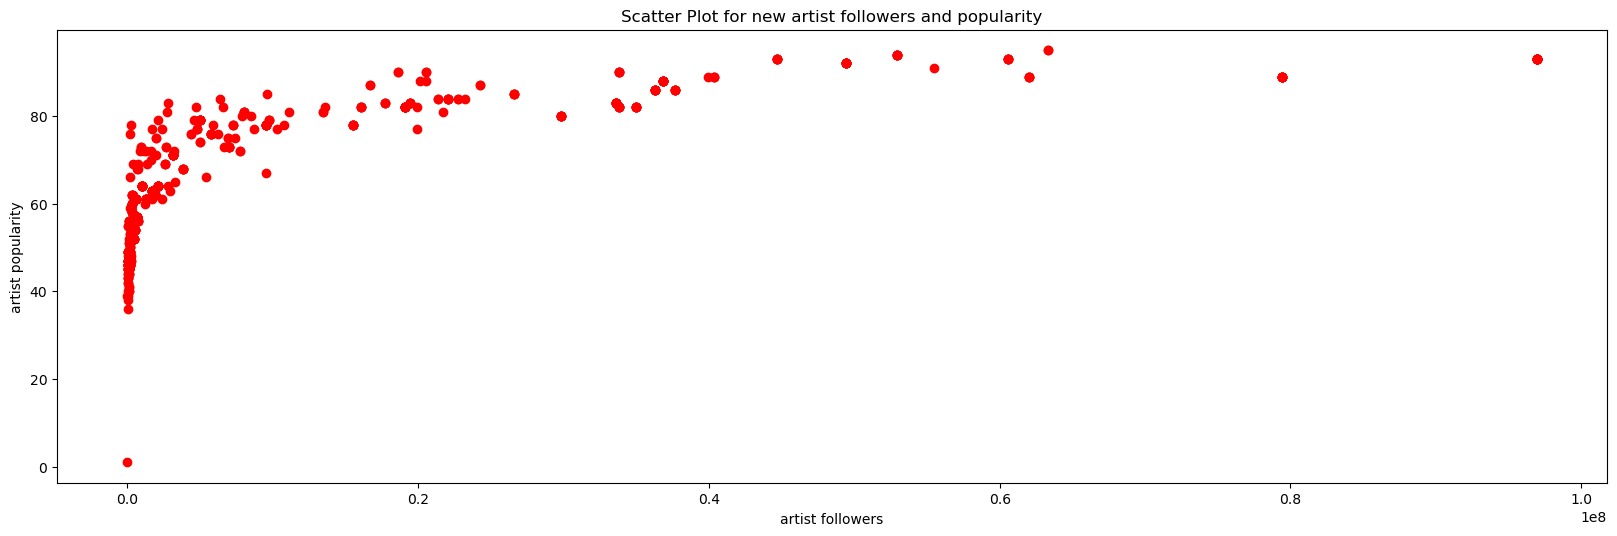

In [ ]:
# 方法 2 - 有趨勢線
plt.figure(figsize=(20, 6))
plt.scatter(taiwan_popular_old["artist_followers"], taiwan_popular_old["artist_popularity"], color="r")
plt.title("Scatter Plot for new artist followers and popularity")
plt.xlabel("artist followers")
plt.ylabel("artist popularity")
plt.show()

#### Conclusion - 歌曲有上熱門音樂榜的新人/成熟歌手的 poplularity（忠實粉絲 + 路人粉絲） vs. followers（忠實粉絲）的關係
新人和成熟歌手的分布大致相似，artist follower and popularity 之間有一定程度的正相關。由圖可知，artist follower 相近的新人和成熟歌手的 artist popularity，以成熟歌手的 popularity 較高，且 artist popularity 相近的新人和成熟歌手的 artist follower，也以成熟歌手的 follower。若將新人歌手、成熟歌手一起看，可以發現很多 popularity 偏高的歌手 follower 並不多，推測是因為音樂屬於流行的時尚產業，變化快速、產品生命週期短，歌手容易藉由一兩首歌曲而吸引路人粉絲來聽自己的歌，故 popularity 較容易有上升、下降的變動，但要吸引聽眾成為長期追蹤歌手、喜歡自己大部分的歌曲的忠實 follower 則須長時間耕耘，因此 follower 增加較為困難。此外，follower 的分布不平均，有極少數擁有極大量的 follower，也印證了目前音樂產業中贏者全拿、較難創造巨星的現象———因為資訊、網路的發達，讓觀眾能在短時間內很容易地接觸到大量的歌曲，所以其對歌曲、歌手的忠誠度變得較不易維持，故音樂產業中較難產生巨星。

---------------------

In [ ]:
def binNum(nobs):
    if nobs < 50:
        return 5
    elif nobs < 200:
        return 8
    elif nobs < 500:
        return 10
    elif nobs < 1000:
        return 11
    elif nobs < 5000:
        return 12
    elif nobs < 50000:
        return 15
    else:
        return 20

def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    #print("x_square_sum = ", x_square_sum)
    size = x.size
    #print("size = ", size)
    x_d = np.zeros((size))
    #print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    #print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

def histogramLog(SD, binNum):
    counts, bins, patches = plt.hist(SD, binNum, density=False, facecolor='g', alpha=0.75)
    plt.xlabel('Standardized Residual')
    plt.ylabel('Frequency')
    plt.title('Histogram of Standardized Residual')
    plt.grid(True)
    bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
    plt.show()

def qqplotLog(SD):
    fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

def shapiroLog(SD):
    print('Shapiro Test')
    stat, p = stats.shapiro(SD)
    print("p value:", p)
    
def homo_hetroLog(SD, df):
    y_pre = -8.66 + 0.1593 * df['loudness'] + 0.2186 * df['artist_popularity'] + 0.2281 * df['experience']
    plt.figure(figsize=(10,20))
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel('predicted values of y')
    plt.ylabel('Standardized Residual')
    plt.show()
    

def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    #print('runs_exp = ', runs_exp)
    #print('stan_dev = ', stan_dev)
    #print('z = ', z)
    print('pval_z = ', pval_z)
    if pval_z < 0.05:
        print(f"Because p value = {pval_z} < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance that randomness doesn't exist, which means the errors are not independent.")
    else:
        print(f"Because p value = {pval_z} > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance that randomness exists, which means the errors are independent.")


#### 七、Fit Regression Model
* 依據先前假設檢定的結果，利用這些較可能對新人歌曲熱門程度有影響的因素 fit logistic model，看能否預測新人歌曲是熱門歌曲的機率。將放入 model 的變數有 danceability, loudness, artist_followers, artist_popularity, experience。
* 從新人歌曲集中挑出 10 首熱門歌曲、10 首非熱門歌曲，其餘的資料會用來 fit regression model。被挑出來的 20 筆會用最後 fit 出的 model 預測該新人歌曲為熱門歌曲的機率，並與實際狀況比較。

##### separate data for testing and fitting model

In [ ]:
taiwan_popular_new_cp = taiwan_popular_new.copy()
taiwan_popular_new_cp['popular'] = 1
taiwan_notPopular_new_cp = taiwan_notPopular_new.copy()
taiwan_notPopular_new_cp['popular'] = 0

taiwan_popular_new_cp = taiwan_popular_new_cp.reset_index()
index = list(range(taiwan_popular_new_cp.shape[0]))
taiwan_popular_new_cp['index'] = index 
test = taiwan_popular_new_cp[taiwan_popular_new_cp['index'] % 8 == 0]
taiwan_popular_new_cp = taiwan_popular_new_cp[taiwan_popular_new_cp['index'] % 8 != 0]

taiwan_notPopular_new_cp = taiwan_notPopular_new_cp.reset_index()
index = list(range(taiwan_notPopular_new_cp.shape[0]))
taiwan_notPopular_new_cp['index'] = index
test = pd.concat([test, taiwan_notPopular_new_cp[taiwan_notPopular_new_cp['index'] % 15 == 0]])
taiwan_notPopular_new_cp = taiwan_notPopular_new_cp[taiwan_notPopular_new_cp['index'] % 15 != 0]
taiwan_new = pd.concat([taiwan_notPopular_new_cp, taiwan_popular_new_cp])

display(test)
display(taiwan_new)

,index,title,artist,artist_id,genres,release_date,danceability,energy,key,loudness,...,tempo,duration_ms,year,artist_release_year,artist_followers,artist_popularity,experience,old_new,drama_movie,popular
0,0,IDGAF,Dua Lipa,6M2wZ9GZgrQXHCFfjv46we,"['dance pop', 'pop', 'uk pop']",2017-06-02,0.836,0.5440,7,-5.975,...,97.028,217947,2018,2016-06-28,33835060,90,2,1,False,1
8,8,Love Lies (with Normani),Khalid,6LuN9FCkKOj5PcnpouEgny,"['pop', 'pop r&b']",2018-02-14,0.708,0.6480,6,-5.626,...,143.955,201707,2018,2017-01-20,15224308,86,1,1,False,1
16,16,Let Me,ZAYN,5ZsFI1h6hIdQRw2ti0hz81,"['dance pop', 'electropop', 'pop', 'post-teen ...",2018-04-12,0.460,0.5670,9,-5.637,...,168.419,185703,2018,2016-02-26,19944824,77,2,1,False,1
24,24,Big Plans,Why Don't We,2jnIB6XdLvnJUeNTy5A0J2,"['boy band', 'dance pop', 'electropop', 'pop',...",2019-01-17,0.693,0.6040,11,-5.279,...,75.014,179930,2019,2017-05-19,3199222,72,2,1,False,1
32,32,Talk (feat. Disclosure),Khalid,6LuN9FCkKOj5PcnpouEgny,"['pop', 'pop r&b']",2019-04-05,0.900,0.4000,0,-8.575,...,135.984,197573,2019,2017-01-20,15224308,86,2,1,False,1
40,40,最後一次,高爾宣 OSN,4TcOznbEZBqev21LzAH4KE,"['mandopop', 'taiwan hip hop', 'taiwan pop']",2019-04-30,0.708,0.6390,5,-4.173,...,89.993,166000,2020,2018-01-29,257792,54,2,1,False,1
48,48,WANNABE,ITZY,2KC9Qb60EaY0kW4eH68vr3,['k-pop girl group'],2020-03-09,0.809,0.9110,6,-4.410,...,122.035,191242,2020,2019-02-12,4149814,73,1,1,False,1
56,56,你的答案,阿冗,3dTgjg7lzUGiD3NwcGCK1n,"['chinese viral pop', 'mainland chinese pop']",2019-11-06,0.458,0.4750,3,-6.631,...,175.912,219874,2021,2019-11-06,39998,50,2,1,False,1
64,64,別再想見我,許光漢,3hhUgkTf3fFYGogFMbV5Wv,"['mandopop', 'taiwan pop']",2020-10-27,0.452,0.3710,8,-9.450,...,141.903,270026,2021,2020-10-27,17147,46,1,1,False,1
72,72,走建國路回家但後座少ㄌ泥,多多 x 以捷,25vtw3bkiKz9nbo7vl6qqY,['mandopop'],2021-05-30,0.465,0.4850,4,-4.666,...,138.776,271383,2021,2021-05-30,4661,34,0,1,False,1


,index,title,artist,artist_id,genres,release_date,danceability,energy,key,loudness,...,tempo,duration_ms,year,artist_release_year,artist_followers,artist_popularity,experience,old_new,drama_movie,popular
1,1,月出 (電視劇《皓鑭傳》片頭曲),陸虎,6J8fujK96bLdDY9CcNhnpM,['chinese drama ost'],2019-06-01 00:00:00,0.300,0.334,5,-10.753,...,154.379,253879,0,2018-10-05,1996,29,1,1,True,0
2,2,望爱却步,于洋,3WwZvtJoVs8siDJlT9Nlxr,[],2018-01-01 00:00:00,0.635,0.648,10,-4.103,...,110.019,237958,0,2017-12-14,139,23,1,1,False,0
3,3,俏书生,吕炸炸,3JRWB2A0zMCnZiS911MfGL,['zhongguo feng'],2020-10-23 00:00:00,0.727,0.556,0,-8.438,...,116.041,203033,0,2019-12-27,191,4,1,1,False,0
4,4,傷感,孟可,1eYd7ZK9XCjgUKaCvFH3yw,['chinese soundtrack'],2018-01-08 00:00:00,0.257,0.227,2,-19.878,...,79.976,70169,0,2017-07-24,215,24,1,1,False,0
5,5,花都開好了,賴美雲,2DPb4rebme0svdWDLPz4dc,[],2020-08-11 00:00:00,0.575,0.684,7,-5.514,...,159.994,212625,0,2019-08-14,751,13,1,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,71,MONTERO (Call Me By Your Name),Lil Nas X,7jVv8c5Fj3E9VhNjxT4snq,"['lgbtq+ hip hop', 'pop']",2021-03-31,0.610,0.508,8,-6.682,...,178.818,137876,2021,2019-04-12,10795970,85,2,1,False,1
73,73,错位时空 - 治愈版,小玄子,5dneY5jm0VI7GBg0pqXTrL,[],2021-06-12,0.648,0.519,0,-7.580,...,133.990,211801,2021,2021-04-11,731,41,0,1,False,1
74,74,WITHOUT YOU,The Kid LAROI,2tIP7SsRs7vjIcLrU85W8J,['australian hip hop'],2020-11-06,0.662,0.413,0,-7.357,...,93.005,161385,2021,2020-06-26,3672522,85,1,1,False,1
75,75,嘉宾,张远,3PutidTQajzWO1gTetJReW,['chinese viral pop'],2020-10-26,0.309,0.434,9,-8.880,...,71.585,333629,2021,2020-10-26,2721,49,1,1,False,1


##### first, check the relationship

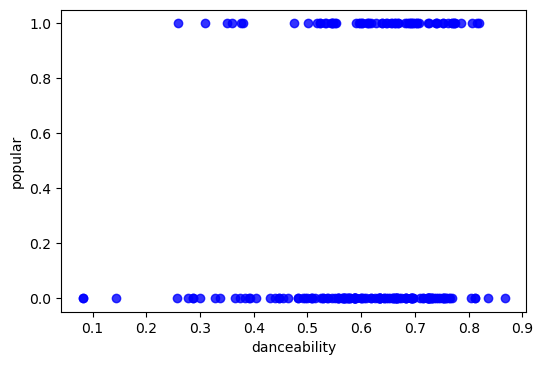

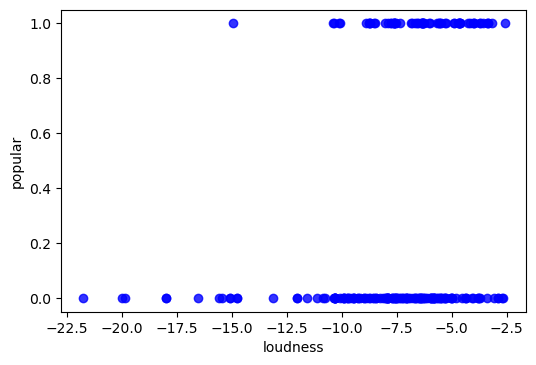

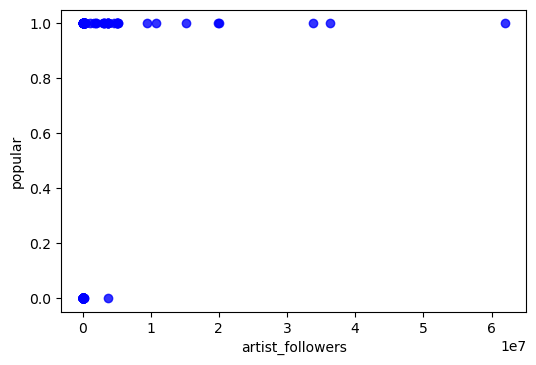

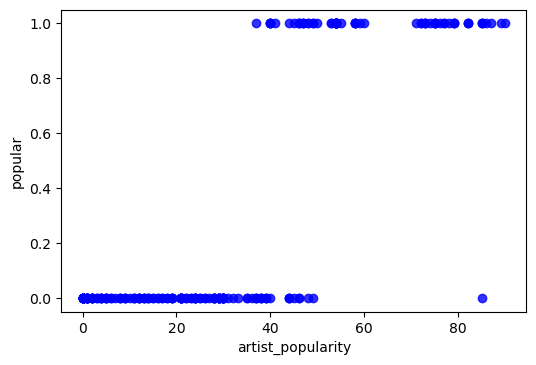

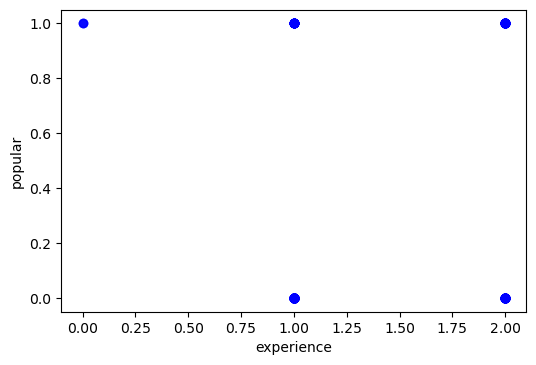

In [ ]:
yCol = 'popular'
xnames = ['danceability', 'loudness', 'artist_followers', 'artist_popularity', 'experience']
df = taiwan_new

y_var = df[yCol].values
for aname in xnames:
    x_var = df[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df, color = 'b', ci = None, fit_reg=False)
    #_ = plt.plot(x, y, 'o', color = 'b')
    plt.xlabel(aname)
    plt.ylabel(yCol)
    plt.show()

#### coefficient of correlation

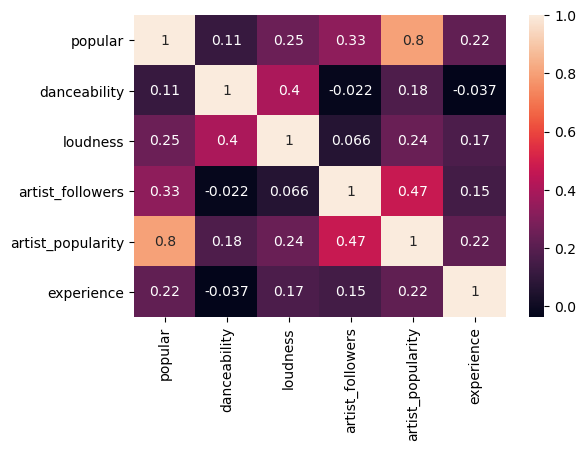

In [ ]:
yCol_and_xCol = [yCol] + xnames
df_a = df[yCol_and_xCol]
corr1 = df_a.corr()
corr1
_ = sns.heatmap(corr1, annot=True)

As the figures and coefficients of correlation show, all x variables seem to have some relationship with y. Therefore, we fit the model and then check the required conditions.

#### fit logistic regression model

In [ ]:
y_data_lr = df[yCol]
X_data_ar_lr = np.array([df['danceability'], df['loudness'], df['artist_followers'], df['artist_popularity'], df['experience']])
X_data_lr_T = X_data_ar_lr.T
X_data_lr = pd.DataFrame(X_data_lr_T, columns = xnames)
X_data_lr = sm.add_constant(X_data_lr)
logit_model = sm.Logit(list(y_data_lr), X_data_lr)
result_reg = logit_model.fit()
print(result_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.163930
         Iterations 9
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.740     
Dependent Variable:  y                AIC:              79.5392   
Date:                2022-05-17 16:14 BIC:              99.5064   
No. Observations:    206              Log-Likelihood:   -33.770   
Df Model:            5                LL-Null:          -129.94   
Df Residuals:        200              LLR p-value:      1.2389e-39
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      9.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
------------------------------------------------------------------
const             -6.4984   2.6894 -2.4163 0.0157 -11.7696 -1.2272
danceability      -3.2147   2.9335 -1.0959 0.2731  -8

#### regression diagnostics 
1. multicollinearity
2. autocorrelation

#### 1. multicollinearity
(1) check whether results that LLR p value and P>|z| infer are consistent. <br>
(2) check whether the coefficients' of correlation sign are the same as the model's coefficients.

In [ ]:
print(result_reg.summary2())

Since the coefficients' of correlation sign are the not same as the model's coefficients, there's multicollinearity. We use stepwise regression (增減變數看是否有改善) to see if we can solve it. We then decide to remove the least significant variable, experience first.

In [ ]:
y_data_lr = df[yCol]
X_data_ar_lr = np.array([df['danceability'], df['loudness'], df['artist_followers'], df['artist_popularity']])
X_data_lr_T = X_data_ar_lr.T
X_data_lr = pd.DataFrame(X_data_lr_T, columns = ['danceability', 'loudness', 'artist_followers', 'artist_popularity'])
X_data_lr = sm.add_constant(X_data_lr)
logit_model = sm.Logit(list(y_data_lr), X_data_lr)
result_reg = logit_model.fit()
print(result_reg.summary2())

The sign of coefficient of danceability is still different from the sign in coefficient of correlation matrix. So we remove the second-least significant variable, danceability, this time.

In [ ]:
y_data_lr = df[yCol]
X_data_ar_lr = np.array([df['loudness'], df['artist_followers'], df['artist_popularity'], df['experience']])
X_data_lr_T = X_data_ar_lr.T
X_data_lr = pd.DataFrame(X_data_lr_T, columns = ['loudness', 'artist_followers', 'artist_popularity', 'experience'])
X_data_lr = sm.add_constant(X_data_lr)
logit_model = sm.Logit(list(y_data_lr), X_data_lr)
result_reg = logit_model.fit()
print(result_reg.summary2())

After removing danceability, the coefficients' of correlation sign are the same as the model's coefficients. Also, since LLR p-value = 3.1029e-40 < 0.05, we can infer at 5% significance level that at least one coefficient isn't 0. Also, since P>|z| for artist_popularity = 0.0000..., we can infer at 5% significance level that its coefficient isn't 0. So the results of F and t tests are consistent. Therefore, there isn't multicollinearity. The heatmap can also show this.

The equation is $\hat{y} = -8.66 + 0.1593\text{loudness} + -0.0000\text{artist_followers} + 0.2186\text{artist_popularity} + 0.2281\text{experience}$

In [ ]:
xnames = ['loudness', 'artist_followers', 'artist_popularity', 'experience']
yCol_and_xCol = [yCol] + xnames
df_a = df[yCol_and_xCol]
corr1 = df_a.corr()
corr1
_ = sns.heatmap(corr1, annot=True)

#### 2. autocorrelation：如果 run 太多或太少，代表不是隨機抽樣，殘差有關聯 (randomness不存在)，可以用 Durbin-Watson 看是哪種關聯

##### [two tail test for first order auto-correlation] 
H0: The data isn't first-order correlated. <br>
H1: The data is first-order correlated.

First, we compute SD. Then, we apply Durbin-Watson test, and check the table in page 961 in the textbook

In [ ]:
SD = result_reg.resid_pearson
nobs = df.shape[0]

k = result_reg.df_model
d_w = Durbin_Watson_test(SD)
print("k =", k)
print("nobs =", nobs)

d =  1.9798197835776312
k = 4.0
nobs = 206


In [ ]:
d_L = 1.633
d_U = 1.715
print("d_L =", d_L)
print("d_U =", d_U) 

print("alpha = 0.02 two tail, nobs = 200")
print(f"[0 - {d_L}) : first order correlation exists")
print(f"[{d_L} - {d_U}] : inconclusive")
print(f"({d_U} - 2] : first order correlation doesn't exist")
print(f"[2 - {4 - d_U}) : first order correlation doesn't exist")
print(f"[{4 - d_U} - {4 - d_L}] : inconclusive")
print(f"({4 - d_L} - 4]: first order correlation exists")

d_L = 1.633
d_U = 1.715
alpha = 0.02 two tail, nobs = 200
[0 - 1.633) : first order correlation exists
[1.633 - 1.715] : inconclusive
(1.715 - 2] : first order correlation doesn't exist
[2 - 2.285) : first order correlation doesn't exist
[2.285 - 2.367] : inconclusive
(2.367 - 4]: first order correlation exists


In [ ]:
d_L = 1.676
d_U = 1.740
print("d_L =", d_L)
print("d_U =", d_U) 

print("alpha = 0.02 two tail, nobs = 250")
print(f"[0 - {d_L}) : first order correlation exists")
print(f"[{d_L} - {d_U}] : inconclusive")
print(f"({d_U} - 2] : first order correlation doesn't exist")
print(f"[2 - {4 - d_U}) : first order correlation doesn't exist")
print(f"[{4 - d_U} - {4 - d_L}] : inconclusive")
print(f"({4 - d_L} - 4]: first order correlation exists")

d_L = 1.676
d_U = 1.74
alpha = 0.02 two tail, nobs = 250
[0 - 1.676) : first order correlation exists
[1.676 - 1.74] : inconclusive
(1.74 - 2] : first order correlation doesn't exist
[2 - 2.26) : first order correlation doesn't exist
[2.26 - 2.324] : inconclusive
(2.324 - 4]: first order correlation exists


We use nobs = 200 and nobs = 250 to estimate the result of nobs = 206. For nobs = 200, d = 1.979 lies in (1.715 - 2], which means we can infer at 2% significance level that first order correlation doesn't exist. Also, for nobs = 250, d = 1.979 lies in (1.74 - 2], which means we can infer at 2% significance level that first order correlation doesn't exist. Since the range of nobs = 206 must be in between the range of nobs = 200 and nobs = 250. Therefore, we can infer at 2% significance level that first order correlation doesn't exist.

#### find outliers

In [ ]:
def outliers(SD):
    df_c = pd.DataFrame(SD,columns = ['SD'])
    filter = (df_c['SD'] < -2) | (df_c['SD'] > 2)
    print("Outliers by SD = \n")
    print(df_c['SD'].loc[filter])

outliers(SD)

Outliers by SD = 

87   -84.892371
Name: SD, dtype: float64


#### find influential observations

In [ ]:
X = np.vstack([np.ones(nobs, dtype=int), X_data_ar_lr])
X = X.T
H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
df['hii'] = np.diagonal(H)
df_h = pd.DataFrame(df['hii'])
k = result_reg.df_model

n = len(df_h['hii'])
h_level = 3 * (k+1) / n 
print("h_level = ", h_level)
print(" \n")
filter = (df_h['hii'] > h_level )
print("Influential Observations by hi = \n")
print(df_h['hii'].loc[filter])
# 真正的id要再加1

h_level =  0.07281553398058252
 

Influential Observations by hi = 

4      0.076548
51     0.076436
101    0.098623
2      0.146931
5      0.187146
17     0.540178
Name: hii, dtype: float64


#### check required conditions - residual analysis
1. The error $\varepsilon$ is a normally distributed random variable.
2. The error $\varepsilon$ is a random variable with mean of zero.
3. The variance of $\varepsilon$, denoted by $\sigma ^ 2$, is the same for all values of the independent variable.
4. The values of $\varepsilon$ are independent.

#### normality testing

[ hypythesis for chi-square test ] <br>
H0: The distribution is normal <br/>
H1: The distribution is not normal

[ hypthesis for Shapiro-wilk test ] <br>
H0: The distribution is normal <br/>
H1: The distribution is not normal

We use histogram, qq-plot, apply chi-square test and Shapiro-wilk test to check if it's normally distributed.

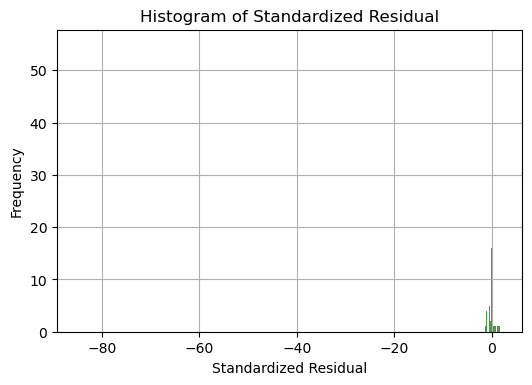

Shapiro Test
p value: 1.7336190685927096e-30


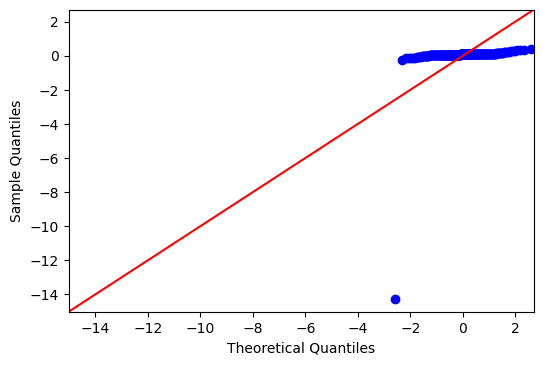

In [ ]:
alpha = 0.05

histogramLog(SD, 'auto')
qqplotLog(SD)
shapiroLog(SD)

The he p value for Shapiro = 1.7336190685927096e-30 < 0.05, there's sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the distribution is not normal. 
It's probably because of the outlier. Since the normality assumption is violated, we can't use the regression model very safely.

We won't remove the outlier in the data. The figure below is just showing that the violation of normality is probably because of the outlier, since after removing the outlier in SD, the histogram looks closer to normal.

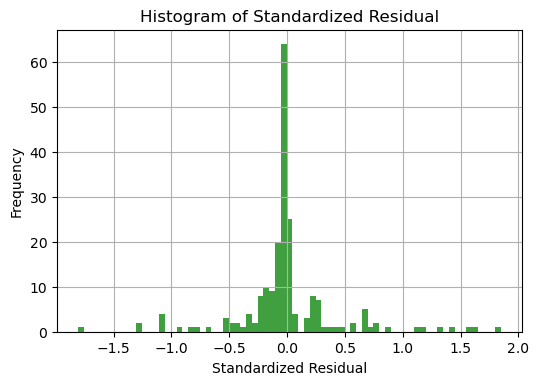

In [ ]:
histogramLog(SD.drop(labels=87), 'auto')

#### Homoscedasticity and Heteroscedasticity

H0: there's homoscedasticity in the distribution of residuals <br>
H1: there's heteroscedasticity in the distribution of residuals

we use the scatter plot to see how residuals spread

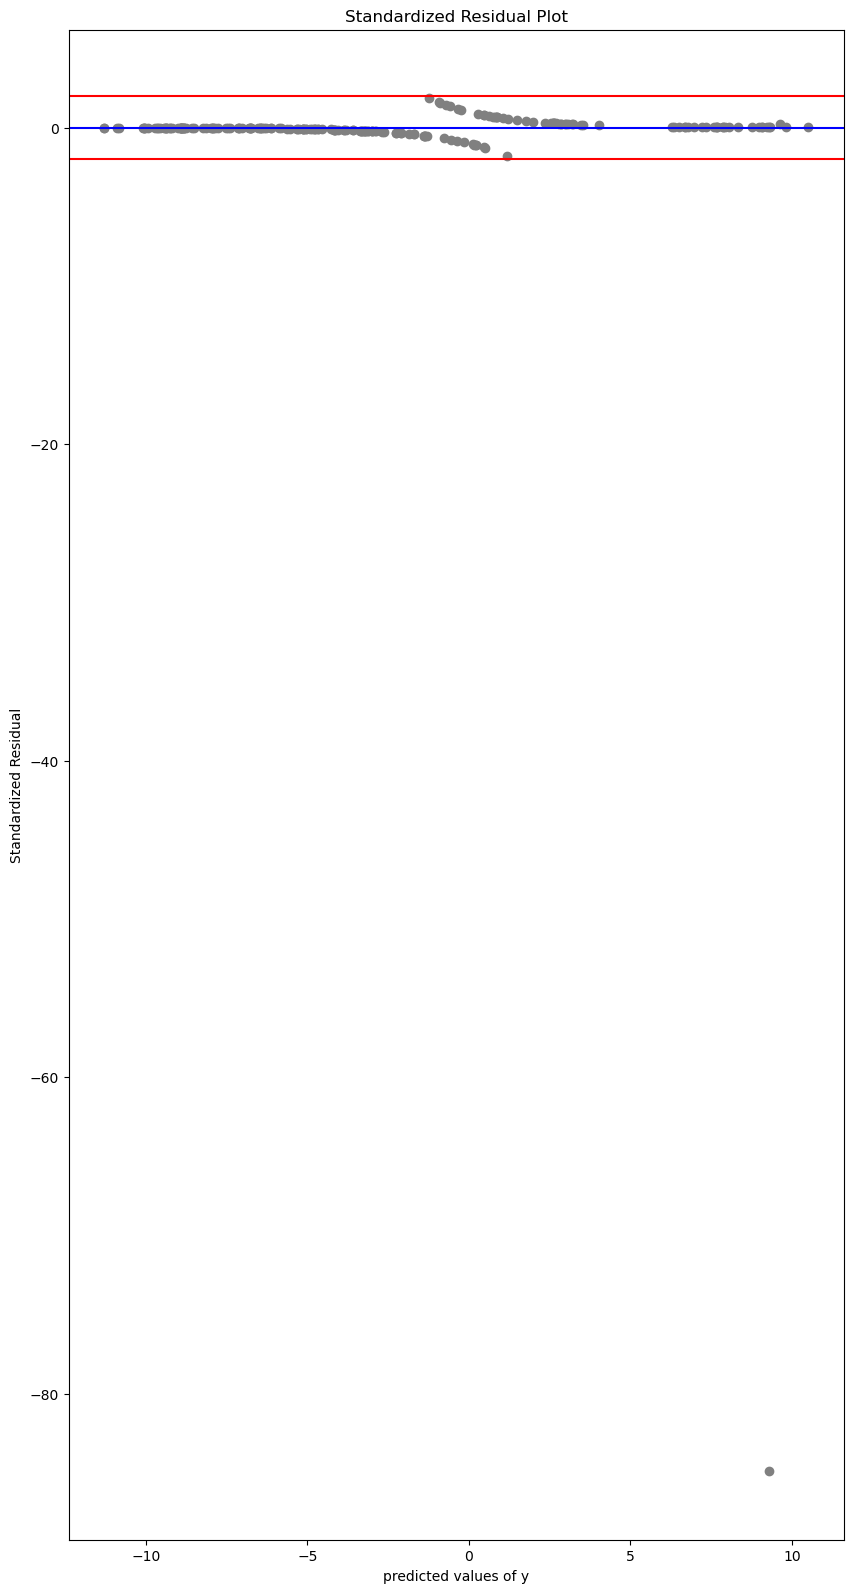

In [ ]:
homo_hetroLog(SD, df)

As the figure shows, there seems to be a certain pattern. Therefore, we reject H0 and assume that the variation is not constant.

#### mean = 0

H0: the mean of residuals is 0 <br>
H1: the mean of residuals isn't 0

Since we've already known that the normality assumption of residuals is not very strong, when we apply t test, we can't use the result very safely.

In [ ]:
h0mean = 0
xbar = SD.mean()                                                       # sample mean
xbar_std = SD.std()                                                    # sample std
alpha = 0.05                                                                 # significance level

# two tail
tcv = stats.t.ppf(1 - alpha / 2, df = nobs - 1)                             
xcv_1 = h0mean - tcv * xbar_std / (nobs ** 0.5)                           
xcv_2 = h0mean + tcv * xbar_std / (nobs ** 0.5)
tvalue = (xbar - h0mean) / (xbar_std / (nobs ** 0.5))
if stats.t.cdf(tvalue, df = nobs - 1) > 0.5:
    pvalue = (1 - stats.t.cdf(tvalue, df = nobs - 1)) * 2 
else:
    pvalue = stats.t.cdf(tvalue, df = nobs - 1) * 2 
# print(f"tcv = {tcv:.4f}")
# print(f"xcv = {xcv_1:.4f}, {xcv_2:.4f}")
# print(f"t-value = {-tvalue:.4f}, {tvalue:.4f}")
print(f"p-value = {pvalue:.4f}")

p-value = 0.3148


Because pvalue = 0.3148 > 0.05, there isn't sufficient evidence to reject H0. Therefore, we can infer at 5% significance level that the mean is 0.

#### randomness

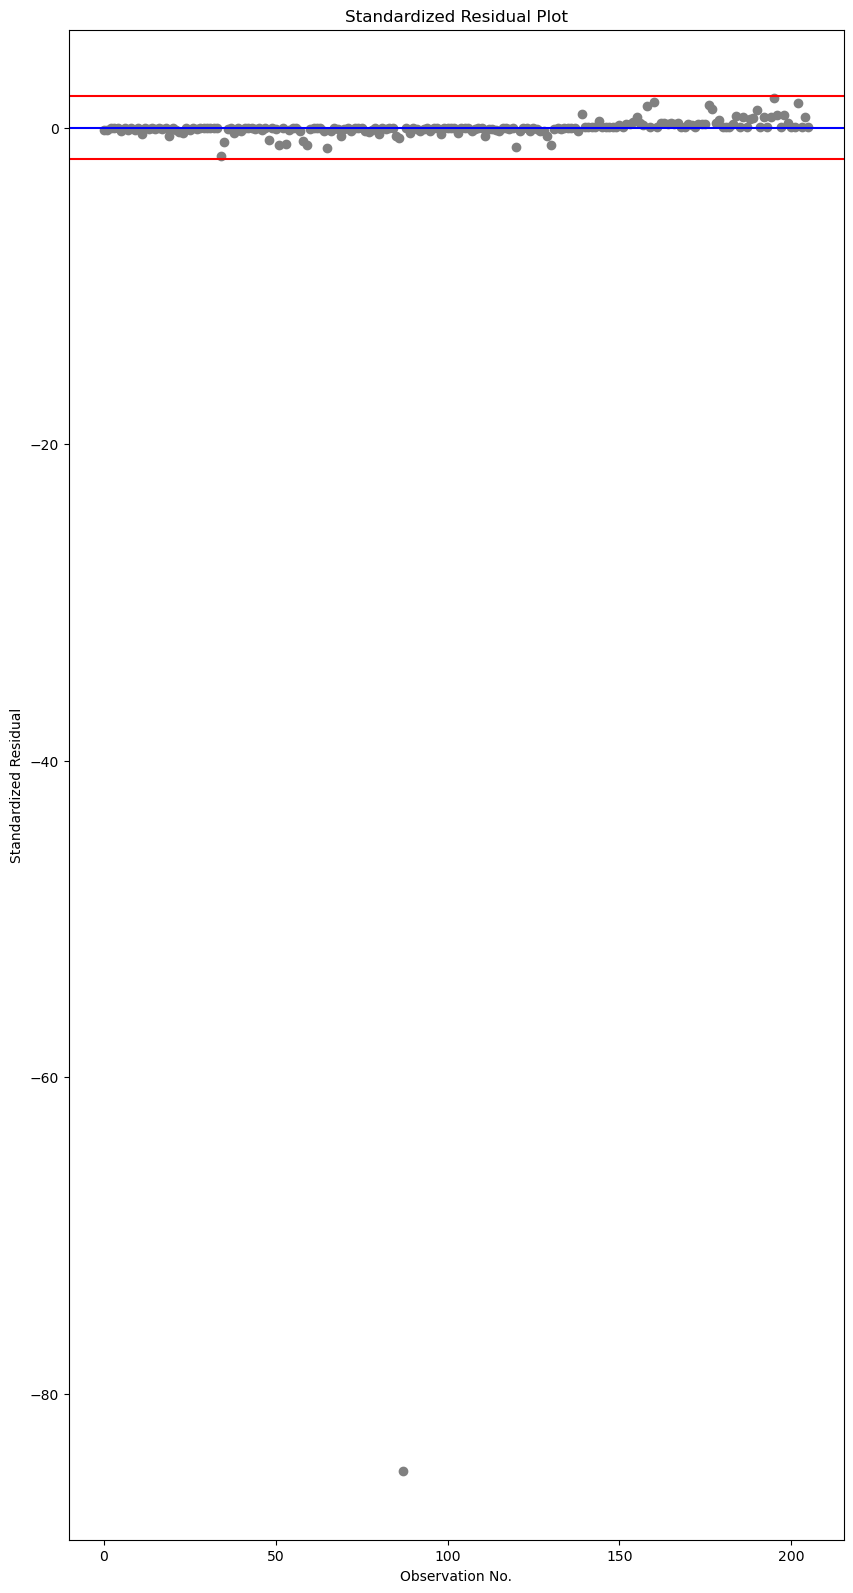

In [ ]:
Id = range(nobs)
plt.figure(figsize=(10, 20))
plt.plot(Id, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Observation No.')
plt.ylabel('Standardized Residual')
plt.show()

As the figure shows, there isn't a very certain pattern.

H0: Randomness exists <br>
H1: Randomness does not exist

apply run test if n1 > 20 or n2 > 20 (otherwise, we need to check run test table)

In [ ]:
SD_median = statistics.median(SD)
runsTest(SD, SD_median) 

runs =  58
n1 =  103
n2 =  103
pval_z =  1.3132001246194922e-10
Because p value = 1.3132001246194922e-10 < 0.05, there is sufficient evidence to reject H0. Therefore, we can infer at 5% significance that randomness doesn't exist, which means the errors are not independent.


Since some required conditions are violated, we can't use the regression model safely.

#### assess the regression model

In [ ]:
print(result_reg.summary2())

                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.735     
Dependent Variable:  y                AIC:              78.7903   
Date:                2022-05-17 16:15 BIC:              95.4297   
No. Observations:    206              Log-Likelihood:   -34.395   
Df Model:            4                LL-Null:          -129.94   
Df Residuals:        201              LLR p-value:      3.1029e-40
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      9.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
------------------------------------------------------------------
const             -8.6600   2.0374 -4.2506 0.0000 -12.6531 -4.6668
loudness           0.1593   0.1376  1.1570 0.2473  -0.1105  0.4290
artist_followers  -0.0000   0.0000 -1.3290 0.1838  -0.0000  0.0000
artist_popularity  0.

The coefficient of determination is r^2 = 0.735, so about 73.5% of the variation in the y is explained by the variation in other variables. The rest remains unexplained by the model. The LLR p value is corresponding to the F test p value in multiple regression model. Since LLR p-value = 3.1029e-40 < 0.05, we can infer at 5% significance level that at least one coefficient isn't 0, and the model is valid. Also, since P>|z| (corresponding to t test) for artist_popularity = 0.0000..., we can infer at 5% significance level that its coefficient isn't 0.

#### use the model to predict

In [ ]:
songs = {'loudness': list(test['loudness']), 
         'artist_followers': list(test['artist_followers']),
         'artist_popularity': list(test['artist_popularity']),
         'experience': list(test['experience'])}
df2 = pd.DataFrame(songs,columns= xnames)
df2 = sm.add_constant(df2)
P_A = result_reg.predict(df2)
df2['Probability'] = P_A
df2['Prob. >= 0.8'] = df2['Probability'] >= 0.7
df2['fact of popular or not'] = test['popular'].values
df2['Prediction Right?'] = (df2['Prob. >= 0.8'] == df2['fact of popular or not'])
display(df2)

print('proportion of predictions that are correct:', df2['Prediction Right?'].mean())

,const,loudness,artist_followers,artist_popularity,experience,Probability,Prob. >= 0.8,fact of popular or not,Prediction Right?
0,1.0,-5.975,33835060,90,2,0.998981,True,1,True
1,1.0,-5.626,15224308,86,1,0.999606,True,1,True
2,1.0,-5.637,19944824,77,2,0.996283,True,1,True
3,1.0,-5.279,3199222,72,2,0.998260,True,1,True
4,1.0,-8.575,15224308,86,2,0.999498,True,1,True
5,1.0,-4.173,257792,54,2,0.948295,True,1,True
6,1.0,-4.410,4149814,73,1,0.998306,True,1,True
7,1.0,-6.631,39998,50,2,0.841119,True,1,True
8,1.0,-9.450,17147,46,1,0.529347,False,1,False
9,1.0,-4.666,4661,34,0,0.122314,False,1,False


proportion of predictions that are correct: 0.85


As the table shows, 9 out of 10 unpopular songs get the probability lower than 4%, while 7 out of 10 popular songs get the probability higher than 94%. If we predict a song to be popular when its probability is >= 0.8, then in this case, 85% of our prediction is correct. And since the probability which the model provided for popular songs and unpopular songs have large difference, we can probably infer that the model is quite good.